In [1]:
!pip install pandas numpy matplotlib xgboost scikit-learn tqdm

# Links
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
* https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

In [126]:
import datetime
import warnings
import pickle
from dataclasses import dataclass
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



warnings.filterwarnings(
    action="ignore",
    message=".*Could not infer format.*",
)

warnings.filterwarnings(
    action="ignore",
    message=".*autologging encountered a warning.*",
)

def load_numeric(file, datetime_to_numeric=True):
    csv = pd.read_csv(file)

    csv['created_date'] = pd.to_datetime(csv['created_date'])
    csv['refitted_date'] = pd.to_datetime(csv['refitted_date'])
    csv['refitted_date'] = csv['refitted_date'].fillna(csv['created_date'])
    
    csv['sale_date'] = pd.to_datetime(csv['sale_date'])
    age_baseline = max(csv["created_date"].max(), csv["refitted_date"].max(), csv["sale_date"].max())

    calculate_age = lambda x: age_baseline.year - x.year - ((age_baseline.month, age_baseline.day) < (x.month, x.day))
    csv['created_age']  = csv['created_date'].apply(calculate_age)
    csv['refitted_age']  = csv['refitted_date'].apply(calculate_age)
    csv['sale_age']  = csv['sale_date'].apply(calculate_age)
                                                                                                                                      
    if datetime_to_numeric:
        csv['created_date'] = pd.to_numeric(csv['created_date'])
        csv['refitted_date'] = pd.to_numeric(csv['refitted_date'])
        csv['sale_date'] = pd.to_numeric(csv['sale_date'])
    print(csv.select_dtypes(include=['object']).dtypes)
    return csv

def load_train(datetime_to_numeric=True):
    return load_numeric(train_path, datetime_to_numeric=datetime_to_numeric)
def load_test(datetime_to_numeric=True):
    return load_numeric(test_path, datetime_to_numeric=datetime_to_numeric)

def store_submission(alias, test_data, model=None):
    now = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "")
    filename = f"{output_path}/{now}_{alias}_submission"
    test_data[['id', 'price']].to_csv(f'{filename}.csv', index=False)

    if model is not None:
        model_path = f"{filename}.pkl"
        pickle.dump(model, open(model_path, "wb"))
    
def predict_and_store(alias, model, test_x):
    test_data = load_test()
    test_data['price'] = model.predict(test_x)
    store_submission(alias, test_data, model)
    return test_data


@dataclass
class LocalDataset:
    X: pd.DataFrame
    y: pd.DataFrame
    X_train: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.DataFrame
    y_test: pd.DataFrame
    test_data: pd.DataFrame
    train_data: pd.DataFrame
    features: list

@dataclass
class ModelTrain:
    X = None
    y = None
    X_train = None
    X_test = None
    y_train  = None
    y_test = None 
    features = None
    model = None


def load_split(datetime_to_numeric=True, test_size=0.3, features=None, drop=None, standard_scaler=True):

    train_data = load_train(datetime_to_numeric=datetime_to_numeric)
    test_data = load_test(datetime_to_numeric=datetime_to_numeric)

    df = train_data
    X = df.drop(['price'], axis=1)
    if drop is not None:
        X = df.drop(drop, axis=1)
        test_data = test_data.drop(drop, axis=1)
    if features is None:
        features = list(X.columns)
    else:
        X = X[features]
        print(f"Keeping features {feature}") 
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    if standard_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        test_data = pd.DataFrame(scaler.transform(test_data), columns=X.columns)
        train_data = pd.DataFrame(scaler.transform(train_data[X.columns]), columns=X.columns)
        train_data["price"] = y
    
    return LocalDataset(X, y, X_train, X_test, y_train, y_test, test_data, train_data, features)


ld = load_split()

ld.train_data


Series([], dtype: object)
Series([], dtype: object)


id  sale_date    cabins     decks  bathrooms  producer  \
0     -1.739341  -1.599936 -0.399313 -0.919681  -1.032443  1.183547   
1     -1.739111  -1.599936 -0.399313 -0.919681   1.695834 -0.628910   
2     -1.738881  -1.599936  0.647919  0.931392   0.331696 -0.628910   
3     -1.738651  -1.599936 -0.399313 -0.919681   0.331696  0.769271   
4     -1.738421  -1.599936  0.647919  0.005856   0.331696  0.251426   
...         ...        ...       ...       ...        ...       ...   
15124  1.739984   1.754496 -0.399313 -0.919681   0.331696 -1.146755   
15125  1.740214   1.754496  0.647919  0.931392   0.331696 -0.836048   
15126  1.740444   1.754496 -0.399313 -0.919681  -1.032443  0.354995   
15127  1.740674   1.843473 -1.446544 -0.919681  -1.032443  0.717487   
15128  1.740904   1.870166  0.647919  0.931392   0.331696  0.717487   

       created_date  refitted_date  total_area  crew_area  cabins_area  \
0         -0.812401      -0.913750   -0.197606   0.301954    -0.525742   
1          0.723333       0.654329    0.128530  -0.260475    -0.855724   
2          0.609800       0.538404    0.537732   0.687935     1.124172   
3         -0.570384      -0.666636   -0.216700   0.335038    -0.427969   
4          0.254717       0.175843    0.718273   1.702512     0.623087   
...             ...            ...         ...        ...          ...   
15124      0.453751       0.379068    0.769275  -0.745708    -0.464634   
15125      0.766317       0.698218   -0.197658  -0.072999     0.280883   
15126     -0.228850      -0.317909   -0.282318  -0.205335    -0.599071   
15127     -1.025918      -1.131764   -0.213612  -0.767764    -1.307923   
15128     -1.637035      -1.755752   -0.256586   1.834849     0.794189   

       maintenance_area  crew_area_coef  total_area_coef  \
0              1.582053       -0.193076        -0.278724   
1              1.042702       -0.854522        -0.231722   
2             -0.665243        1.159212         0.908859   
3              1.469688        0.027406        -0.238138   
4              2.323661        1.232706         2.606666   
...                 ...             ...              ...   
15124         -0.665243        1.409091         0.635503   
15125         -0.665243        0.144996        -0.210694   
15126          0.683135       -0.163679        -0.336704   
15127          0.840445       -1.574762        -0.244709   
15128          2.278715        0.262586        -0.313899   

       weight_distribution_x  weight_distribution_y  engine_thrust    radar  \
0                  -1.211682               0.251690       0.289805 -0.08502   
1                   1.269955               1.530472      -0.246808 -0.08502   
2                   1.355039               1.345943       1.507745 -0.08502   
3                  -1.381852              -0.064236      -0.329305 -0.08502   
4                   0.163854               2.159452       1.223231 -0.08502   
...                      ...                    ...            ...      ...   
15124              -1.112417               1.688435      -0.438686 -0.08502   
15125               0.298571               1.159259      -0.860541 -0.08502   
15126              -0.835891              -0.882771       0.319608 -0.08502   
15127              -0.672813              -0.925852      -1.443702 -0.08502   
15128              -0.637361              -0.805944       1.026438 -0.08502   

       bow_thruster  autopilot  solar_panels  navi_quality     state  \
0          1.170324  -1.535115     -0.118644     -0.302077  0.920486   
1          1.170324   0.651417     -0.118644     -0.302077  0.920486   
2         -0.854464  -1.535115     -0.118644     -0.302077 -0.626071   
3          1.170324   0.651417     -0.118644      2.345002  0.920486   
4          1.170324   0.651417     -0.118644     -0.302077 -0.626071   
...             ...        ...           ...           ...       ...   
15124     -0.854464   0.651417     -0.118644     -0.302077  0.920486   
15125      1.170324   0.6

In [69]:
import pandas as pd

pd.options.display.max_columns = None

output_path = '.'
# test_path = '/kaggle/input/dataset/test.csv'
# train_path = '/kaggle/input/dataset/train.csv'
test_path = 'test.csv'
train_path = 'train.csv'
test_csv = pd.read_csv(test_path)
train_csv = pd.read_csv(train_path)
# sample_submission = pd.read_csv('sample_submission.csv')

def store_dataset(name, train_csv, test_csv):
    train_path = f'{name}_train.csv'
    test_path = f'{name}_test.csv'
    train_csv.to_csv(train_path, index=False)
    test_csv.to_csv(test_path, index=False)
    with wandb.init() as run:
        ds_art = wandb.Artifact(name=name, 
                                            type='dataset',
                                            description=f'{name} dataset'
                                         )
        ds_art.add_file(train_path)
        ds_art.add_file(test_path)
        table = wandb.Table(dataframe=load_train().sample(1000))
        wandb.log({'dataset': table})
        run.log_artifact(ds_art)   
    
    import mlflow.data
    from mlflow.data.pandas_dataset import PandasDataset
    
    mlflow.set_experiment("dataset")
    train_dataset: PandasDataset = mlflow.data.from_pandas(train_csv, source=train_path)
    test_dataset: PandasDataset = mlflow.data.from_pandas(test_csv, source=test_path)
    
    with mlflow.start_run():
        mlflow.log_input(train_dataset, context="training")
        mlflow.log_input(train_dataset, context="test")

    
    # Retrieve the run, including dataset information
    run = mlflow.get_run(mlflow.last_active_run().info.run_id)
    dataset_info = run.inputs.dataset_inputs[0].dataset
    print(f"Dataset name: {dataset_info.name}")
    print(f"Dataset digest: {dataset_info.digest}")
    print(f"Dataset profile: {dataset_info.profile}")
    print(f"Dataset schema: {dataset_info.schema}")
    
    # Load the dataset's source, which downloads the content from the source URL to the local
    # filesystem
    dataset_source = mlflow.data.get_source(dataset_info)
    dataset_source.load()

store_dataset("original", train_csv, test_csv)

Series([], dtype: object)


/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'original_train.csv'. Exception: 
  return _dataset_source_registry.resolve(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'original_test.csv'. Exception

Dataset name: dataset
Dataset digest: f22d56f4
Dataset profile: {"num_rows": 15129, "num_elements": 378225}
Dataset schema: {"mlflow_colspec": [{"type": "long", "name": "id", "required": true}, {"type": "double", "name": "price", "required": true}, {"type": "string", "name": "sale_date", "required": true}, {"type": "long", "name": "cabins", "required": true}, {"type": "double", "name": "decks", "required": true}, {"type": "long", "name": "bathrooms", "required": true}, {"type": "long", "name": "producer", "required": true}, {"type": "string", "name": "created_date", "required": true}, {"type": "string", "name": "refitted_date", "required": false}, {"type": "double", "name": "total_area", "required": true}, {"type": "double", "name": "crew_area", "required": true}, {"type": "double", "name": "cabins_area", "required": true}, {"type": "double", "name": "maintenance_area", "required": true}, {"type": "double", "name": "crew_area_coef", "required": true}, {"type": "double", "name": "total_

/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [20]:
ld.train_data

id      price            sale_date  cabins  decks  bathrooms  \
0          1  1845000.0  4825267200000000000       3    1.0          1   
1          2   861600.0  4825267200000000000       3    1.0          3   
2          3  1446000.0  4825267200000000000       4    2.0          2   
3          4  2250000.0  4825267200000000000       3    1.0          2   
4          5  1200000.0  4825267200000000000       4    1.5          2   
...      ...        ...                  ...     ...    ...        ...   
15124  15125  1005000.0  4857840000000000000       3    1.0          2   
15125  15126  1080000.0  4857840000000000000       4    2.0          2   
15126  15127  2565000.0  4857840000000000000       3    1.0          1   
15127  15128  1336500.0  4858704000000000000       2    1.0          1   
15128  15129  3930000.0  4858963200000000000       4    2.0          2   

       producer         created_date        refitted_date  total_area  \
0            59  4310064000000000000  4310064000000000000       364.6   
1            24  4594060800000000000  4594060800000000000       998.3   
2            24  4573065600000000000  4573065600000000000      1793.4   
3            51  4354819200000000000  4354819200000000000       327.5   
4            41  4507401600000000000  4507401600000000000      2144.2   
...         ...                  ...                  ...         ...   
15124        14  4544208000000000000  4544208000000000000      2243.3   
15125        20  4602009600000000000  4602009600000000000       364.5   
15126        43  4417977600000000000  4417977600000000000       200.0   
15127        50  4270579200000000000  4270579200000000000       333.5   
15128        50  4157568000000000000  4157568000000000000       250.0   

       crew_area  cabins_area  maintenance_area  crew_area_coef  \
0          118.0         68.0              50.0            93.0   
1           92.5         54.5              38.0            70.5   
2          135.5        135.5               0.0           139.0   
3          119.5         72.0              47.5           100.5   
4          181.5        115.0              66.5           141.5   
...          ...          ...               ...             ...   
15124       70.5         70.5               0.0           147.5   
15125      101.0        101.0               0.0           104.5   
15126       95.0         65.0              30.0            94.0   
15127       69.5         36.0              33.5            46.0   
15128      187.5        122.0              65.5           108.5   

       total_area_coef  weight_distribution_x  weight_distribution_y  \
0                275.0              -0.070052               0.016326   
1                335.8               0.104948               0.105376   
2               1811.2               0.110948               0.092526   
3                327.5              -0.082052              -0.005674   
4               4007.4               0.026948               0.149176   
...                ...                    ...                    ...   
15124           1457.6              -0.063052               0.116376   
15125            363.0               0.036448               0.079526   
15126            200.0              -0.043552              -0.062674   
15127            319.0              -0.032052              -0.065674   
15128            229.5              -0.029552              -0.057324   

       engine_thrust  radar  bow_thruster  autopilot  solar_panels  \
0             1899.6      0             1          0             0   
1             1550.3      0             1          1             0   
2             2692.4      0             0          0             0   
3             1496.6      0             1          1             0   
4             2507.2      0             1          1             0   
...              ...    ...           ...        ...           ...   
15124         1425.4      0             0          1             0   
15125         

In [21]:
ld.train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15129 entries, 0 to 15128
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     15129 non-null  int64  
 1   price                  15129 non-null  float64
 2   sale_date              15129 non-null  int64  
 3   cabins                 15129 non-null  int64  
 4   decks                  15129 non-null  float64
 5   bathrooms              15129 non-null  int64  
 6   producer               15129 non-null  int64  
 7   created_date           15129 non-null  int64  
 8   refitted_date          15129 non-null  int64  
 9   total_area             15129 non-null  float64
 10  crew_area              15129 non-null  float64
 11  cabins_area            15129 non-null  float64
 12  maintenance_area       15129 non-null  float64
 13  crew_area_coef         15129 non-null  float64
 14  total_area_coef        15129 non-null  float64
 15  we

In [22]:
ld.train_data.columns

Index(['id', 'price', 'sale_date', 'cabins', 'decks', 'bathrooms', 'producer',
       'created_date', 'refitted_date', 'total_area', 'crew_area',
       'cabins_area', 'maintenance_area', 'crew_area_coef', 'total_area_coef',
       'weight_distribution_x', 'weight_distribution_y', 'engine_thrust',
       'radar', 'bow_thruster', 'autopilot', 'solar_panels', 'navi_quality',
       'state', 'overall_quality', 'created_age', 'refitted_age', 'sale_age'],
      dtype='object')

In [28]:
ld.train_data.describe().apply(lambda s: s.apply('{0:.3f}'.format)).T

count                     mean  \
id                     15129.000                 7565.000   
price                  15129.000              1615166.704   
sale_date              15129.000  4840817692325996544.000   
cabins                 15129.000                    3.375   
decks                  15129.000                    1.496   
bathrooms              15129.000                    1.755   
producer               15129.000                   36.126   
created_date           15129.000  4458578118738845696.000   
refitted_date          15129.000  4473963800594884096.000   
total_area             15129.000                  758.711   
crew_area              15129.000                  104.191   
cabins_area            15129.000                   89.522   
maintenance_area       15129.000                   14.668   
crew_area_coef         15129.000                   99.536   
total_area_coef        15129.000                  637.684   
weight_distribution_x  15129.000                    0.015   
weight_distribution_y  15129.000                   -0.000   
engine_thrust          15129.000                 1708.800   
radar                  15129.000                    0.007   
bow_thruster           15129.000                    0.422   
autopilot              15129.000                    0.701   
solar_panels           15129.000                    0.013   
navi_quality           15129.000                    0.232   
state                  15129.000                    3.410   
overall_quality        15129.000                    7.660   
created_age            15129.000                   12.189   
refitted_age           15129.000                   11.704   
sale_age               15129.000                    0.070   

                                          std                      min  \
id                                   4367.510                    1.000   
price                             1077825.899               225000.000   
sale_date                9756430801137656.000  4825267200000000000.000   
cabins                                  0.944                    0.000   
decks                                   0.540                    1.000   
bathrooms                               0.738                    0.000   
producer                               19.257                    1.000   
created_date           184889823880962496.000  4007836800000000000.000   
refitted_date          181181677333221792.000  4007836800000000000.000   
total_area                           2046.136                   26.000   
crew_area                              45.964                   19.000   
cabins_area                            41.458                   19.000   
maintenance_area                       22.164                    0.000   
crew_area_coef                         34.324                   20.000   
total_area_coef                      1316.442                   32.600   
weight_distribution_x                   0.070                   -0.138   
weight_distribution_y                   0.069                   -0.109   
engine_thrust                         655.789                 -377.300   
radar                                   0.085                    0.000   
bow_thruster                            0.494                    0.000   
autopilot                               0.458                    0.000   
solar_panels                            0.115                    0.000   
navi_quality                            0.763                    0.000   
state                                   0.649                    1.000   
overall_quality                         1.174                    3.000   
created_age                             5.840                    3.000   
refitted_age                            5.723                    3.000   
sale_age                                0.255                    0.000   

                                           25%                      50%  \
id                                 

In [29]:
all_features = list(test_csv.columns)
test_csv.columns

Index(['id', 'sale_date', 'cabins', 'decks', 'bathrooms', 'producer',
       'created_date', 'refitted_date', 'total_area', 'crew_area',
       'cabins_area', 'maintenance_area', 'crew_area_coef', 'total_area_coef',
       'weight_distribution_x', 'weight_distribution_y', 'engine_thrust',
       'radar', 'bow_thruster', 'autopilot', 'solar_panels', 'navi_quality',
       'state', 'overall_quality'],
      dtype='object')

# SelectKBest features

* https://lifewithdata.com/2022/03/19/feature-selection-with-selectkbest-in-scikit-learn/

In [137]:
def select_features(k=12):
    from sklearn.feature_selection import SelectKBest, chi2
    from sklearn.preprocessing import MinMaxScaler

    selector = SelectKBest(score_func=chi2, k=k)
    ld = load_split()
    X = ld.X
    y = ld.y

    sc = MinMaxScaler()
    X_sc = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

    # X_new contains the selected features
    X_new = selector.fit_transform(X_sc, y)

    kept_features = pd.DataFrame({'columns': X.columns,
                                  'Kept': selector.get_support()})

    new_X = pd.DataFrame(X.iloc[:,selector.get_support()])
    print(list(new_X.columns))

    test_data = ld.test_data[new_X.columns]
    # test_data = pd.DataFrame(test_data.iloc[:,selector.get_support()])

    train_data = new_X
    train_data["price"] = ld.train_data["price"]
    return LocalDataset(new_X, ld.y, sc.transform(ld.X_train), sc.transform(ld.X_test), ld.y_train, ld.y_test, test_data, train_data, kept_features)
    
ld_kbest = select_features(12)

store_dataset("kbest-12", ld_kbest.train_data, ld_kbest.test_data)

ld_kbest.X

Series([], dtype: object)
Series([], dtype: object)
['sale_date', 'decks', 'maintenance_area', 'weight_distribution_y', 'radar', 'bow_thruster', 'autopilot', 'solar_panels', 'navi_quality', 'created_age', 'refitted_age', 'sale_age']


/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Series([], dtype: object)


Dataset name: dataset
Dataset digest: acb02bb7
Dataset profile: {"num_rows": 15129, "num_elements": 196677}
Dataset schema: {"mlflow_colspec": [{"type": "long", "name": "sale_date", "required": true}, {"type": "double", "name": "decks", "required": true}, {"type": "double", "name": "maintenance_area", "required": true}, {"type": "double", "name": "weight_distribution_y", "required": true}, {"type": "long", "name": "radar", "required": true}, {"type": "long", "name": "bow_thruster", "required": true}, {"type": "long", "name": "autopilot", "required": true}, {"type": "long", "name": "solar_panels", "required": true}, {"type": "long", "name": "navi_quality", "required": true}, {"type": "long", "name": "created_age", "required": true}, {"type": "long", "name": "refitted_age", "required": true}, {"type": "long", "name": "sale_age", "required": true}, {"type": "double", "name": "price", "required": true}]}


/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'kbest-12_train.csv'. Exception: 
  return _dataset_source_registry.resolve(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'kbest-12_test.csv'. Exception

sale_date  decks  maintenance_area  weight_distribution_y  \
0      4825267200000000000    1.0              50.0               0.016326   
1      4825267200000000000    1.0              38.0               0.105376   
2      4825267200000000000    2.0               0.0               0.092526   
3      4825267200000000000    1.0              47.5              -0.005674   
4      4825267200000000000    1.5              66.5               0.149176   
...                    ...    ...               ...                    ...   
15124  4857840000000000000    1.0               0.0               0.116376   
15125  4857840000000000000    2.0               0.0               0.079526   
15126  4857840000000000000    1.0              30.0              -0.062674   
15127  4858704000000000000    1.0              33.5              -0.065674   
15128  4858963200000000000    2.0              65.5              -0.057324   

       radar  bow_thruster  autopilot  solar_panels  navi_quality  \
0          0             1          0             0             0   
1          0             1          1             0             0   
2          0             0          0             0             0   
3          0             1          1             0             2   
4          0             1          1             0             0   
...      ...           ...        ...           ...           ...   
15124      0             0          1             0             0   
15125      0             1          1             0             0   
15126      0             0          0             0             0   
15127      0             0          0             0             0   
15128      0             0          1             0             0   

       created_age  refitted_age  sale_age      price  
0               17            17         1  1845000.0  
1                8             8         1   861600.0  
2                9             9         1  1446000.0  
3               15            15         1  2250000.0  
4               11            11         1  1200000.0  
...            ...           ...       ...        ...  
15124            9             9         0  1005000.0  
15125            8             8         0  1080000.0  
15126           13            13         0  2565000.0  
15127           18            18         0  1336500.0  
15128           22            22         0  3930000.0  

[15129 rows x 13 columns]

# Exploratory Data Analysis (EDA)
* https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/
* https://www.kaggle.com/code/imoore/intro-to-exploratory-data-analysis-eda-in-python
* https://www.tensorflow.org/tutorials/keras/regression?hl=es-419#limpie_la_data
* https://seaborn.pydata.org/tutorial/distributions.html

In [47]:
ld.X.isna().sum()

id                       0
sale_date                0
cabins                   0
decks                    0
bathrooms                0
producer                 0
created_date             0
refitted_date            0
total_area               0
crew_area                0
cabins_area              0
maintenance_area         0
crew_area_coef           0
total_area_coef          0
weight_distribution_x    0
weight_distribution_y    0
engine_thrust            0
radar                    0
bow_thruster             0
autopilot                0
solar_panels             0
navi_quality             0
state                    0
overall_quality          0
created_age              0
refitted_age             0
sale_age                 0
dtype: int64

In [50]:
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.7 MB/s eta 0:00:003.7 MB/s eta 0:00:01


In [88]:
columns = ['id', 'sale_date', 'cabins', 'decks', 'bathrooms', 'producer',
       'created_date', 'refitted_date', 'total_area', 'crew_area',
       'cabins_area', 'maintenance_area', 'crew_area_coef', 'total_area_coef',
       'weight_distribution_x', 'weight_distribution_y', 'engine_thrust',
       'radar', 'bow_thruster', 'autopilot', 'solar_panels', 'navi_quality',
       'state', 'overall_quality']

to_drop = ['id', 'producer']
dates = ['sale_date', 'refitted_date', 'created_date']

2024/05/16 21:22:19 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/05/16 21:22:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


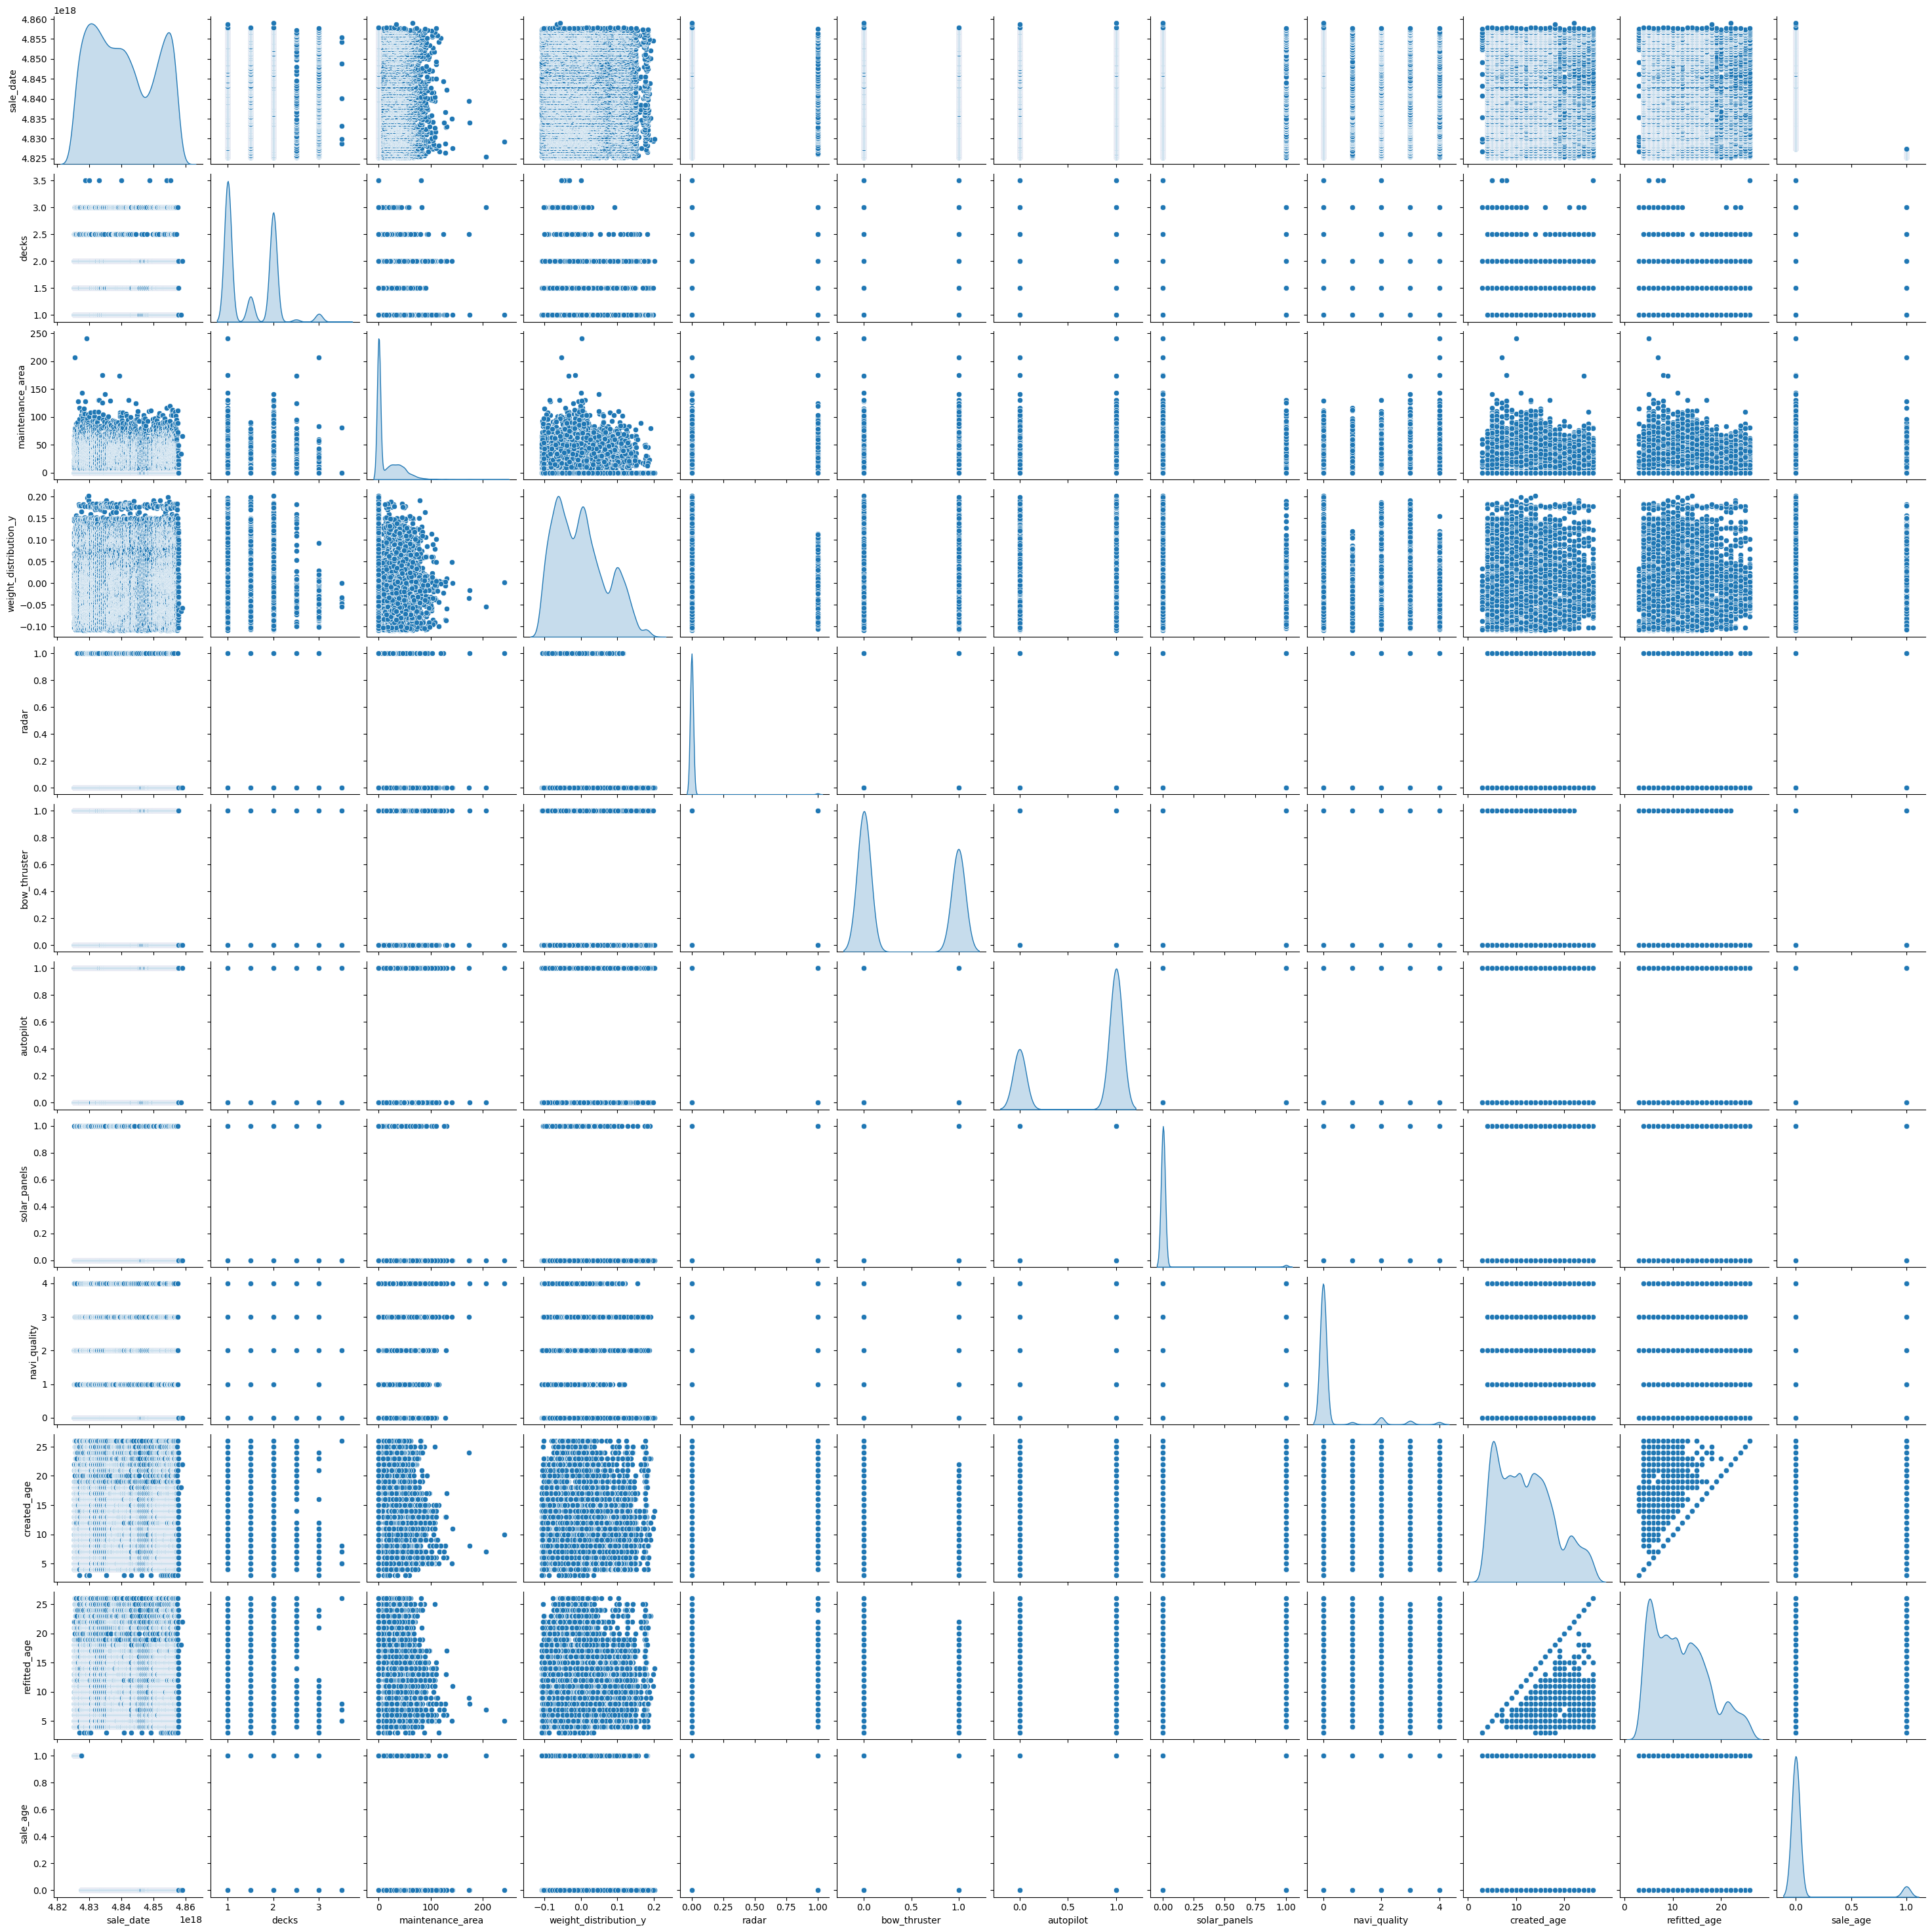

In [48]:
import seaborn as sns

# ld = load_split(datetime_to_numeric=False, standard_scaler=False)

sns.pairplot(ld_kbest.X, diag_kind="kde")

In [49]:
ld.X.describe().T

count          mean           std           min  \
id                     15129.0  7.565000e+03  4.367510e+03  1.000000e+00   
sale_date              15129.0  4.840818e+18  9.756431e+15  4.825267e+18   
cabins                 15129.0  3.375306e+00  9.438567e-01  0.000000e+00   
decks                  15129.0  1.495803e+00  5.396424e-01  1.000000e+00   
bathrooms              15129.0  1.754643e+00  7.377251e-01  0.000000e+00   
producer               15129.0  3.612605e+01  1.925662e+01  1.000000e+00   
created_date           15129.0  4.458578e+18  1.848898e+17  4.007837e+18   
refitted_date          15129.0  4.473964e+18  1.811817e+17  4.007837e+18   
total_area             15129.0  7.587106e+02  2.046136e+03  2.600000e+01   
crew_area              15129.0  1.041907e+02  4.596449e+01  1.900000e+01   
cabins_area            15129.0  8.952228e+01  4.145752e+01  1.900000e+01   
maintenance_area       15129.0  1.466847e+01  2.216435e+01  0.000000e+00   
crew_area_coef         15129.0  9.953636e+01  3.432414e+01  2.000000e+01   
total_area_coef        15129.0  6.376839e+02  1.316442e+03  3.260000e+01   
weight_distribution_x  15129.0  1.524148e-02  7.044182e-02 -1.375518e-01   
weight_distribution_y  15129.0 -3.062838e-04  6.945315e-02 -1.087737e-01   
engine_thrust          15129.0  1.708800e+03  6.557889e+02 -3.773000e+02   
radar                  15129.0  7.336903e-03  8.534374e-02  0.000000e+00   
bow_thruster           15129.0  4.223015e-01  4.939424e-01  0.000000e+00   
autopilot              15129.0  7.005090e-01  4.580502e-01  0.000000e+00   
solar_panels           15129.0  1.348404e-02  1.153391e-01  0.000000e+00   
navi_quality           15129.0  2.324013e-01  7.626458e-01  0.000000e+00   
state                  15129.0  3.409809e+00  6.492676e-01  1.000000e+00   
overall_quality        15129.0  7.659792e+00  1.174096e+00  3.000000e+00   
created_age            15129.0  1.218884e+01  5.839547e+00  3.000000e+00   
refitted_age           15129.0  1.170414e+01  5.722853e+00  3.000000e+00   
sale_age               15129.0  7.013021e-02  2.553748e-01  0.000000e+00   

                                25%           50%           75%           max  
id                     3.783000e+03  7.565000e+03  1.134700e+04  1.512900e+04  
sale_date              4.832179e+18  4.839696e+18  4.850410e+18  4.858963e+18  
cabins                 3.000000e+00  3.000000e+00  4.000000e+00  3.300000e+01  
decks                  1.000000e+00  1.500000e+00  2.000000e+00  3.500000e+00  
bathrooms              1.000000e+00  2.000000e+00  2.000000e+00  8.000000e+00  
producer               2.200000e+01  3.500000e+01  5.300000e+01  7.000000e+01  
created_date           4.333651e+18  4.486234e+18  4.620413e+18  4.738694e+18  
refitted_date          4.352141e+18  4.499453e+18  4.633632e+18  4.738694e+18  
total_area             2.520000e+02  3.825000e+02  5.350000e+02  8.256800e+04  
crew_area              7.150000e+01  9.600000e+01  1.275000e+02  6.770000e+02  
cabins_area            6.000000e+01  7.800000e+01  1.105000e+02  4.705000e+02  
maintenance_area       0.000000e+00  0.000000e+00  2.850000e+01  2.410000e+02  
crew_area_coef         7.450000e+01  9.200000e+01  1.180000e+02  3.105000e+02  
total_area_coef        2.550000e+02  3.816000e+02  5.050000e+02  4.356000e+04  
weight_distribution_x -4.205180e-02  7.448202e-03  5.994820e-02  4.644482e-01  
weight_distribution_y -5.912374e-02 -6.373740e-03  4.492626e-02  2.020763e-01  
engine_thrust          1.276400e+03  1.675800e+03  2.075600e+03  7.236600e+03  
radar                  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
bow_thruster           0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
autopilot              0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
solar_panels           0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
navi_quality           0.000000e+00  0.000000e+00  0.000000e+00  4.000000e+00  
state                  3.000000e+00  3.000000e+00  4.000

id
Skew : 0.0


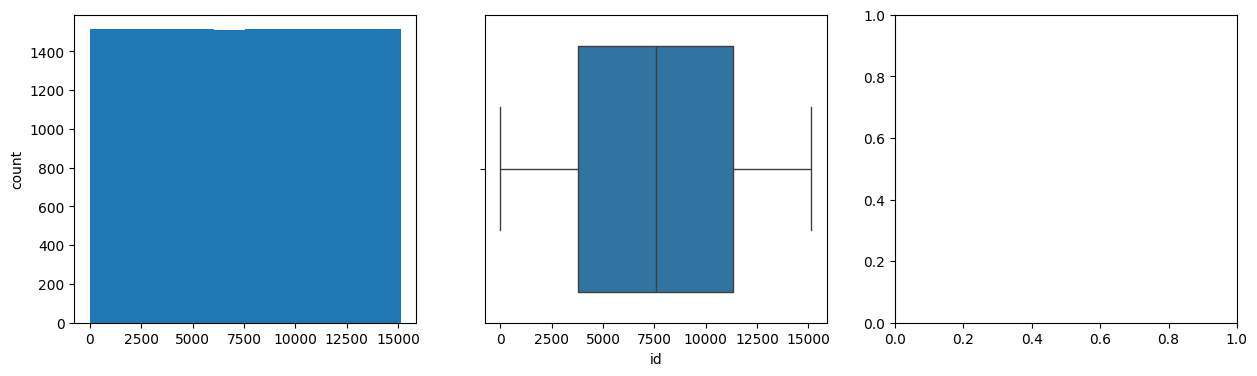

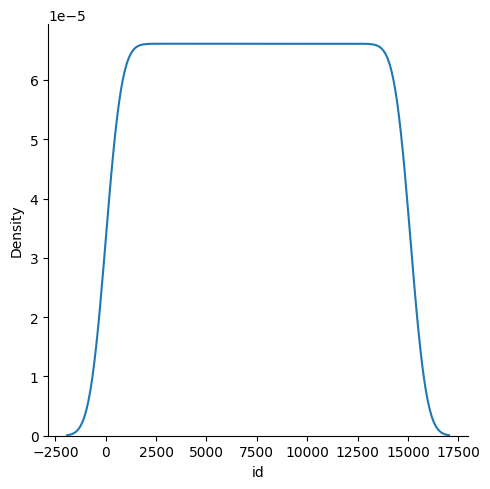

sale_date
Skew : 0.18


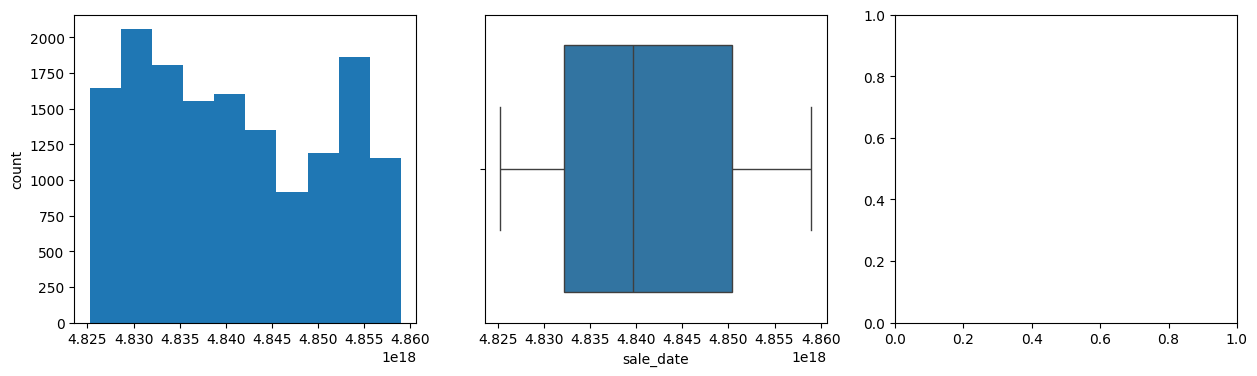

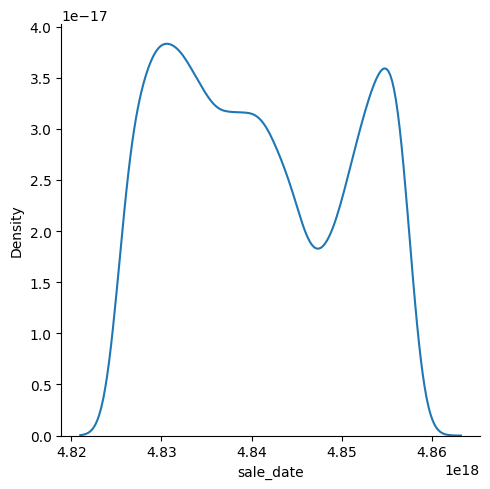

cabins
Skew : 2.52


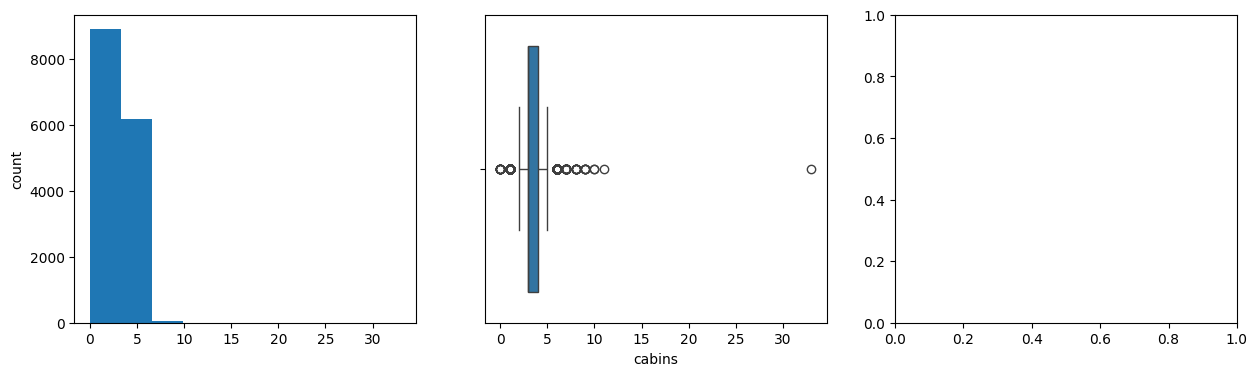

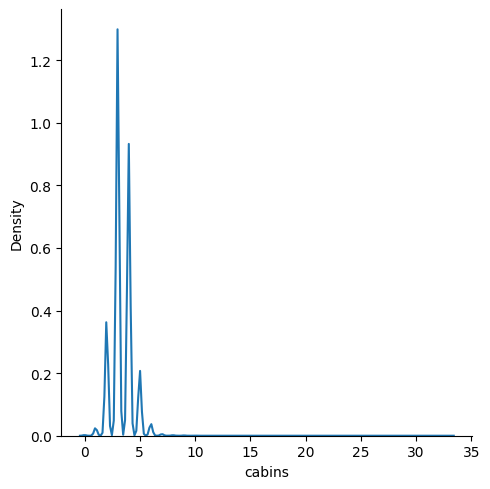

decks
Skew : 0.61


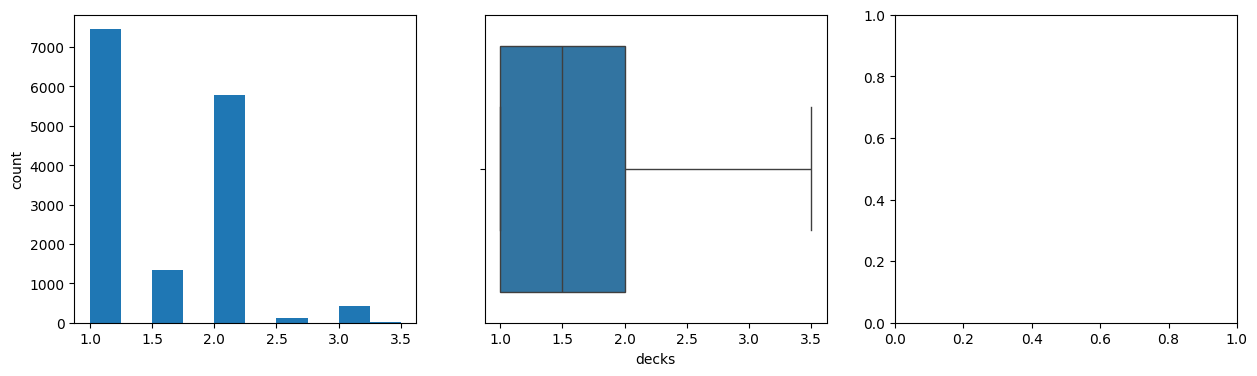

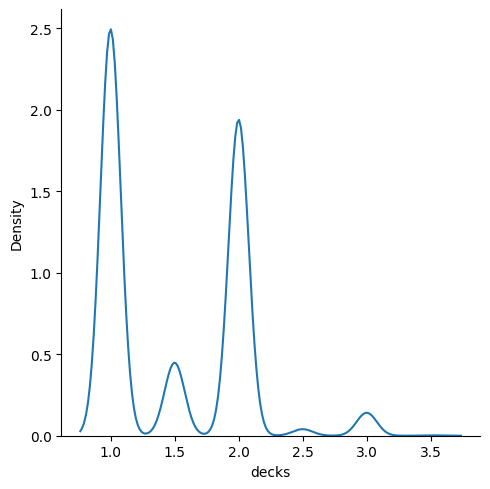

bathrooms
Skew : 0.93


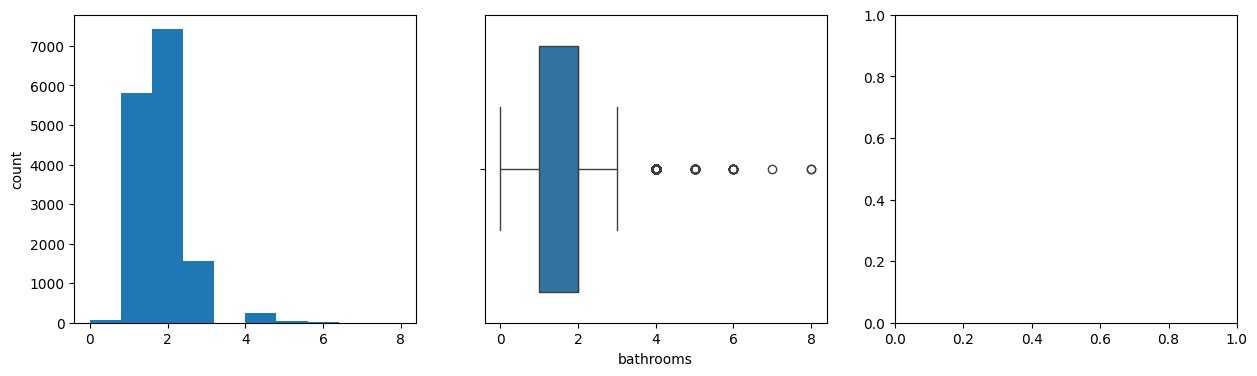

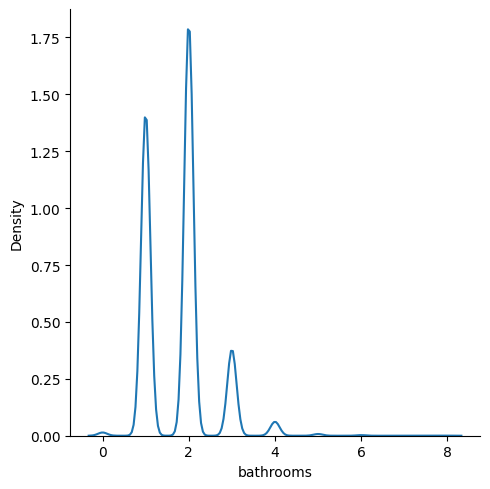

producer
Skew : -0.05


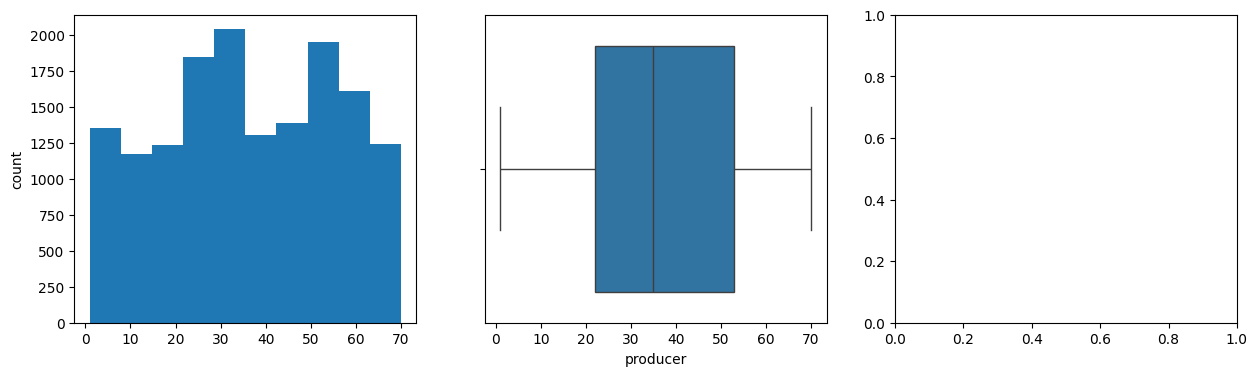

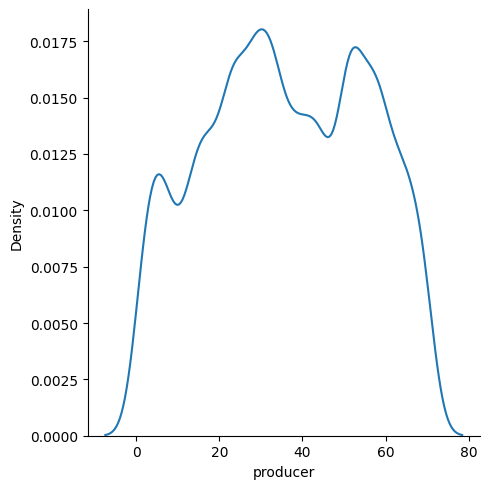

created_date
Skew : -0.48


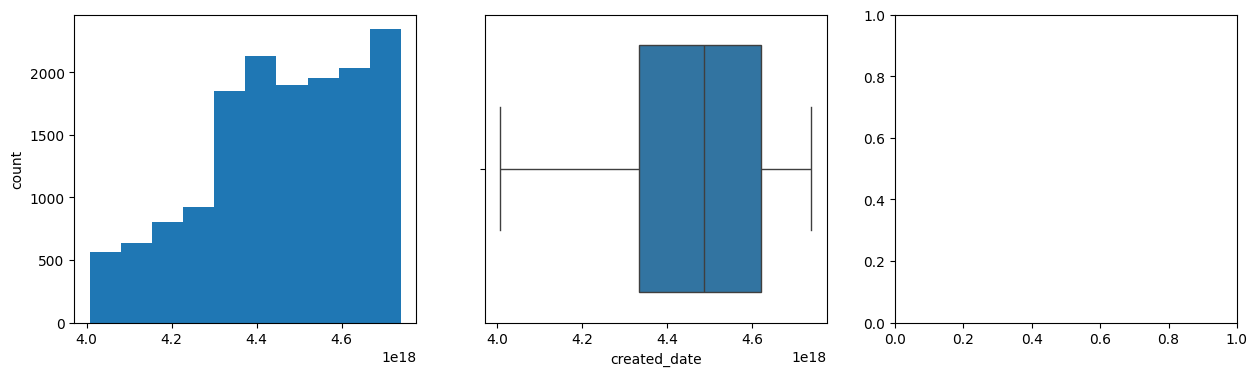

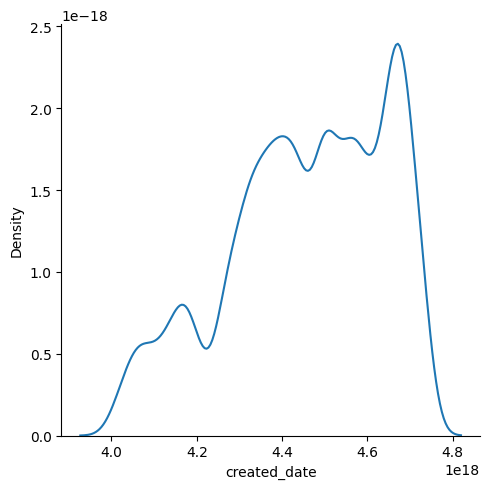

refitted_date
Skew : -0.57


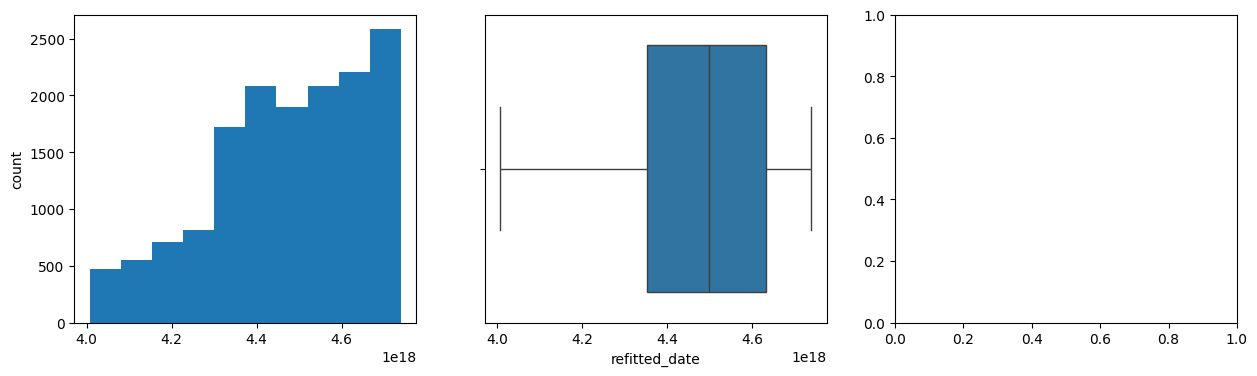

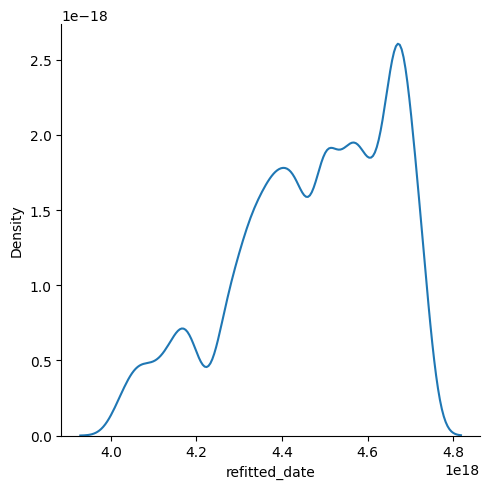

total_area
Skew : 13.38


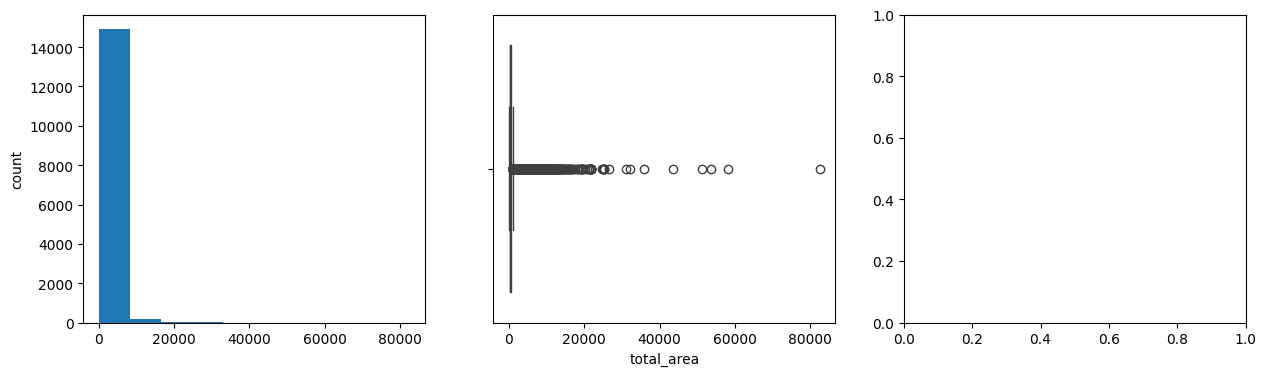

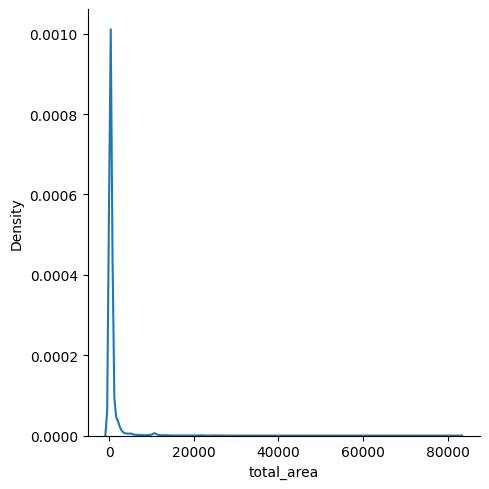

crew_area
Skew : 1.5


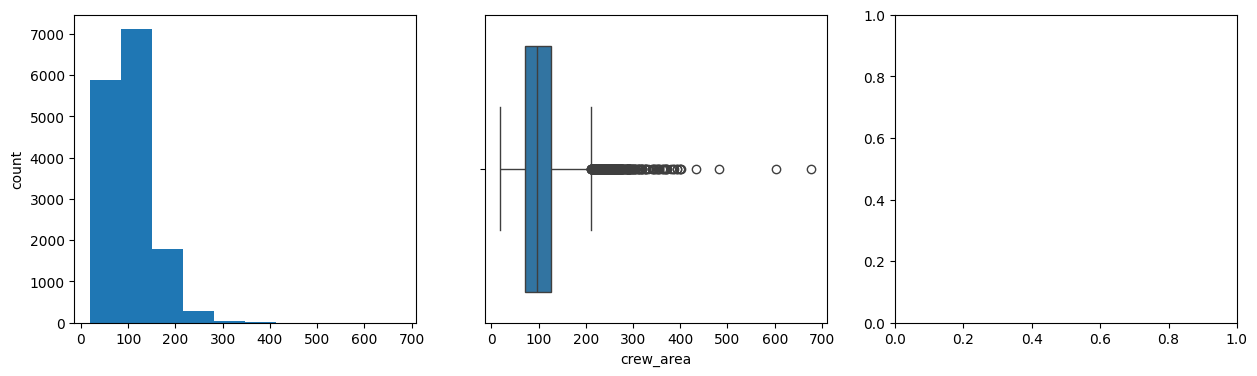

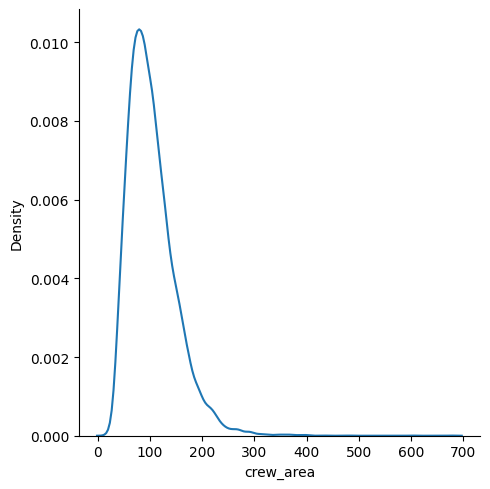

cabins_area
Skew : 1.45


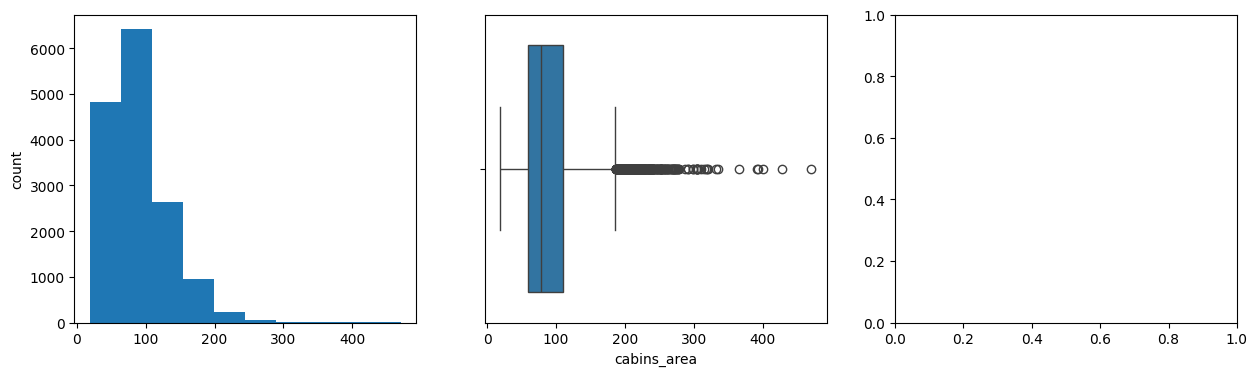

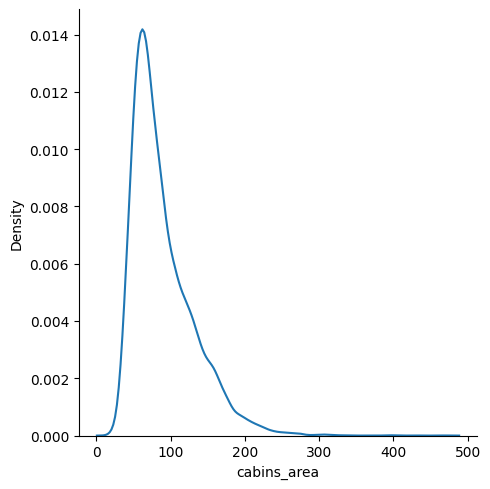

maintenance_area
Skew : 1.58


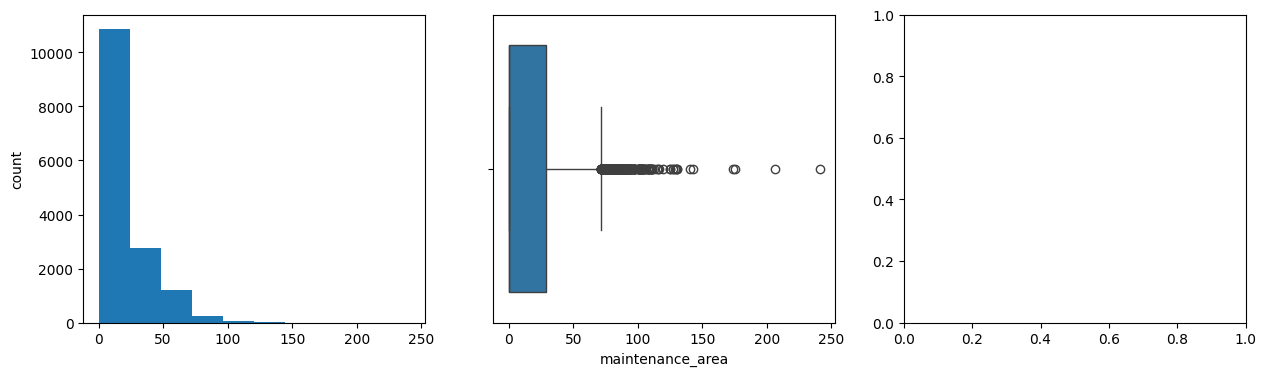

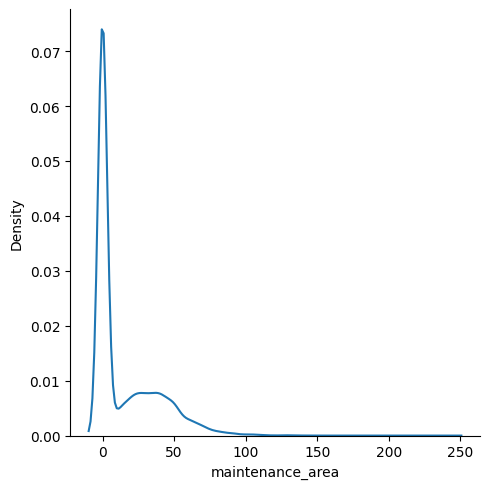

crew_area_coef
Skew : 1.11


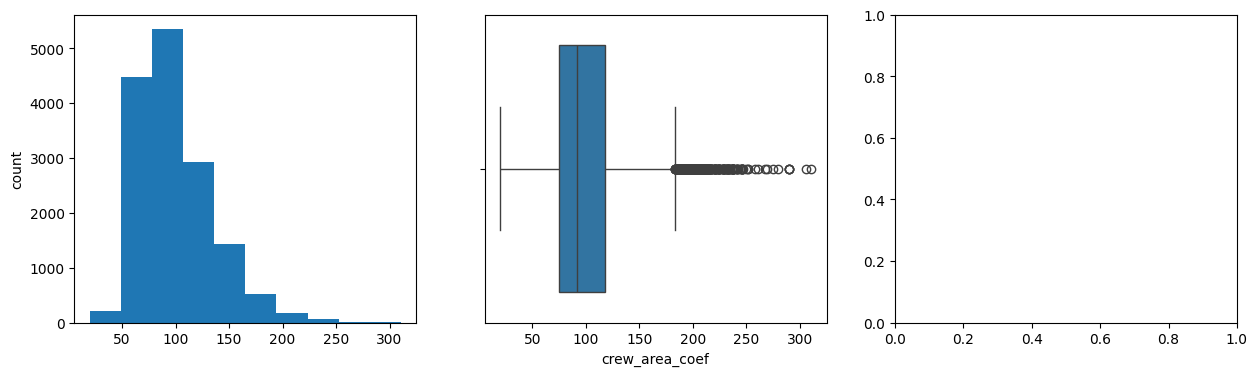

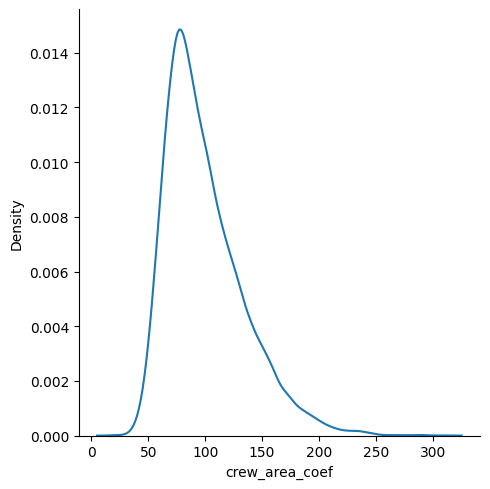

total_area_coef
Skew : 8.83


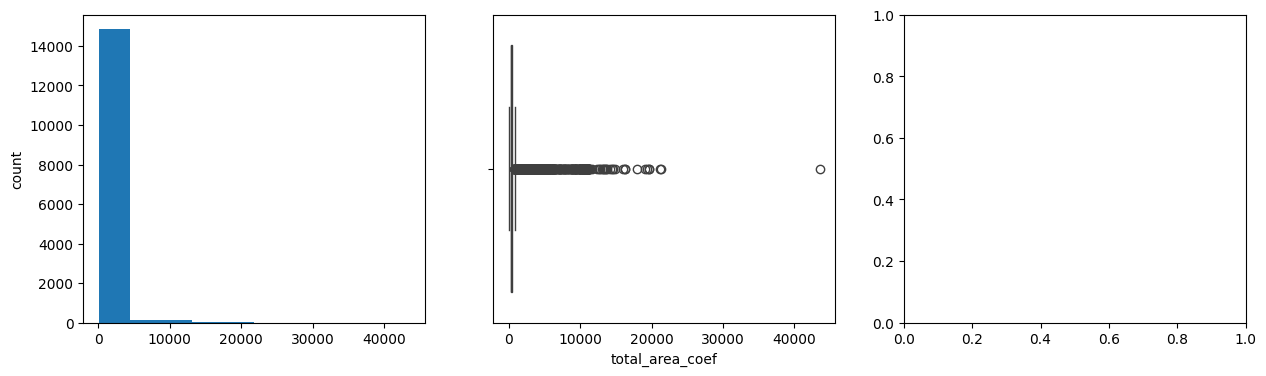

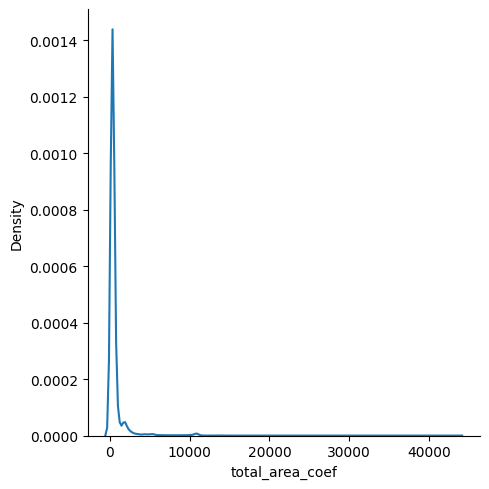

weight_distribution_x
Skew : 0.89


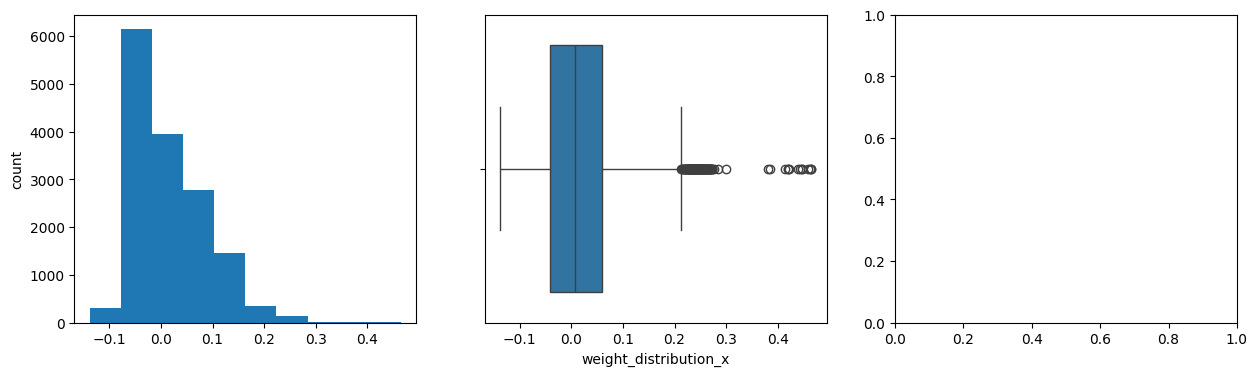

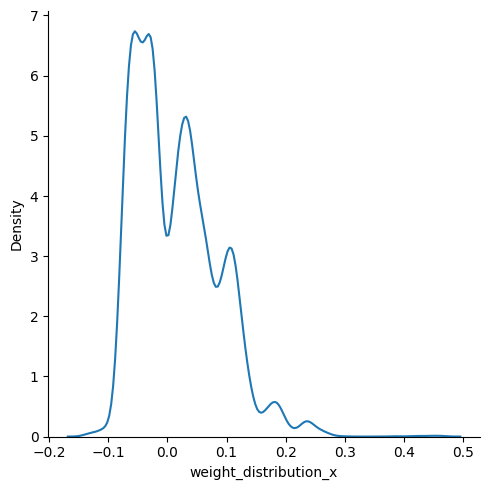

weight_distribution_y
Skew : 0.49


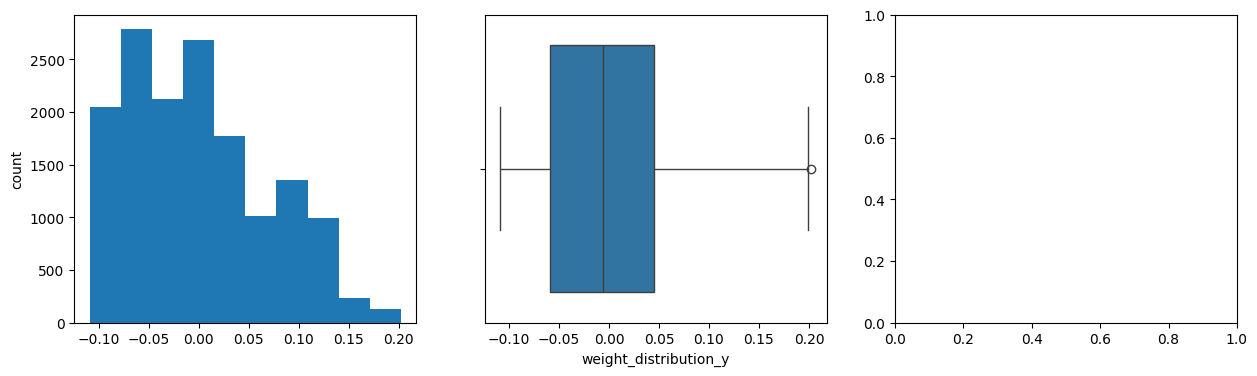

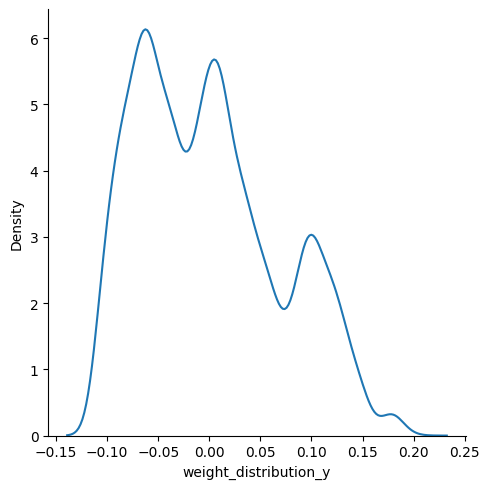

engine_thrust
Skew : 0.73


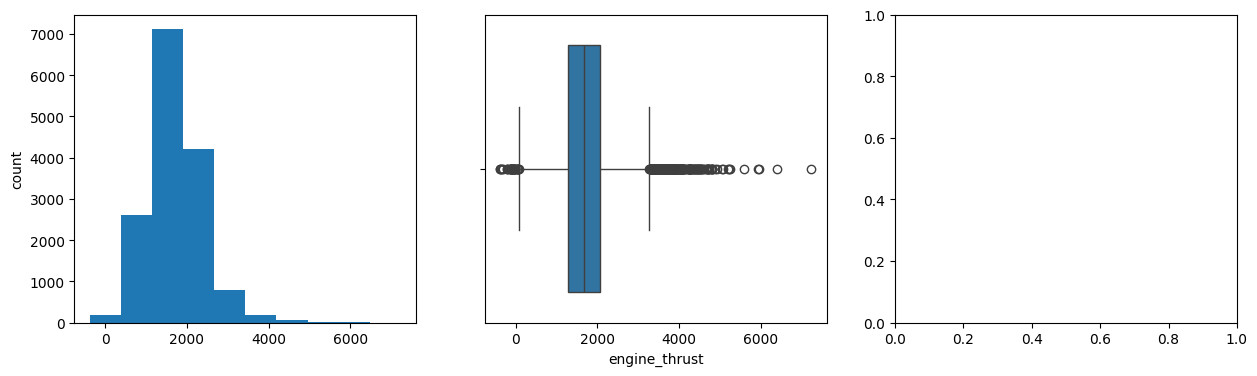

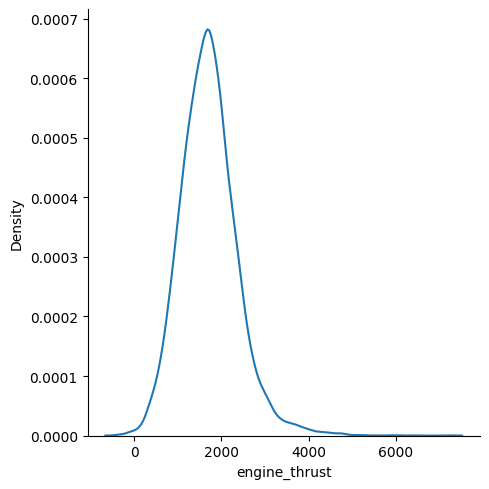

radar
Skew : 11.55


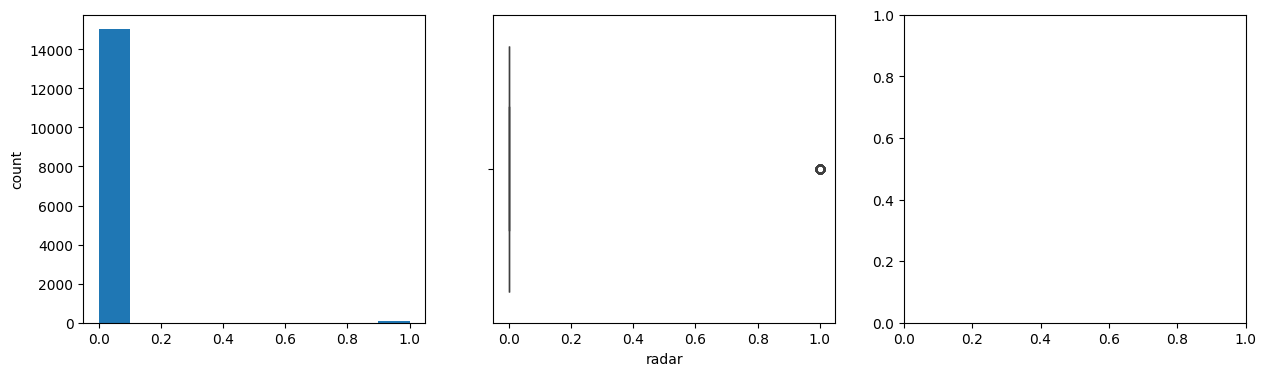

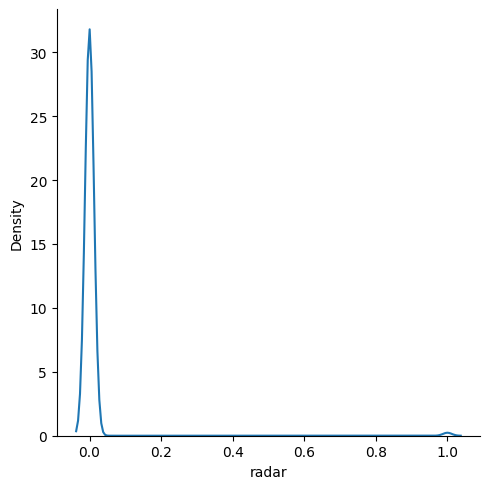

bow_thruster
Skew : 0.31


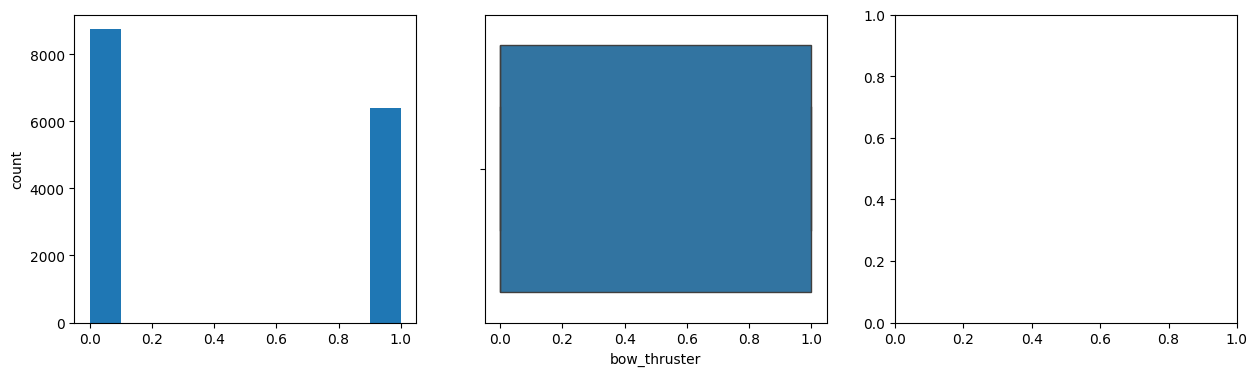

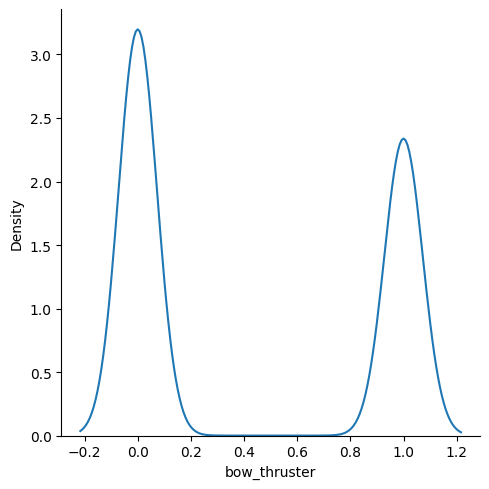

autopilot
Skew : -0.88


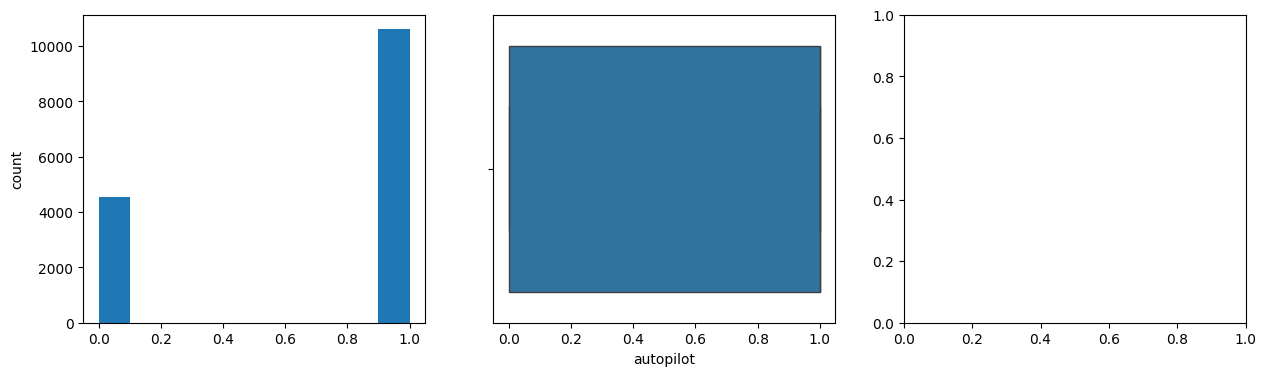

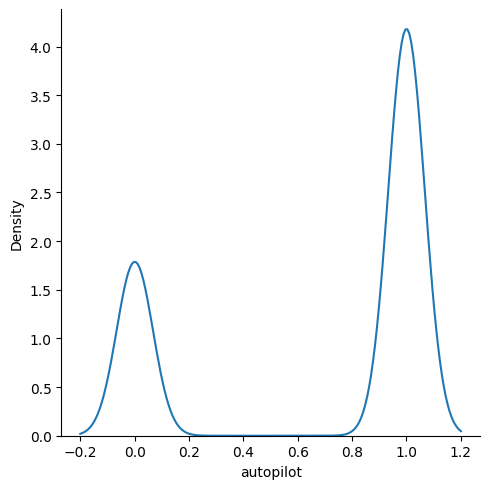

solar_panels
Skew : 8.44


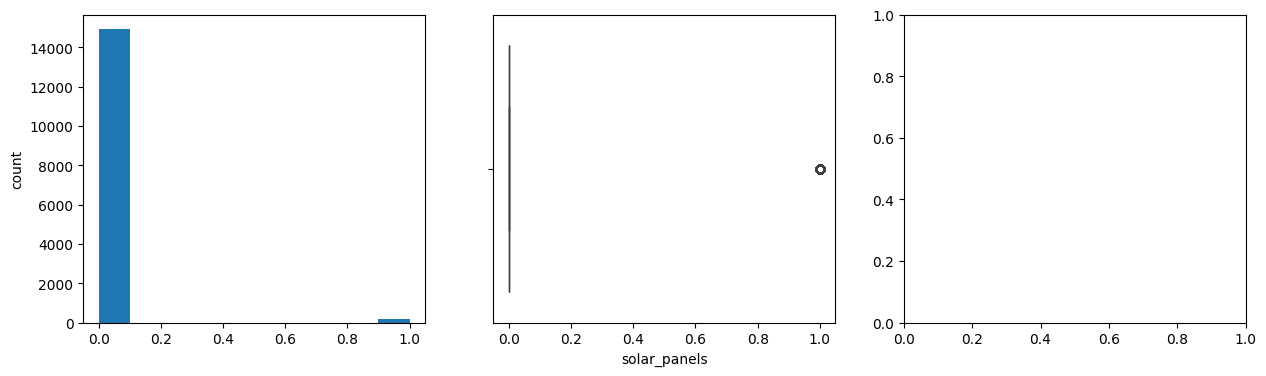

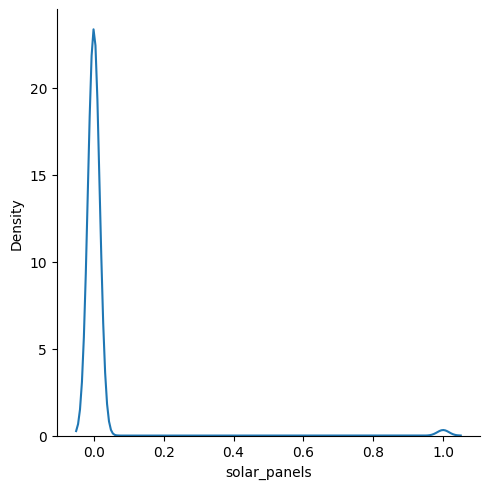

navi_quality
Skew : 3.4


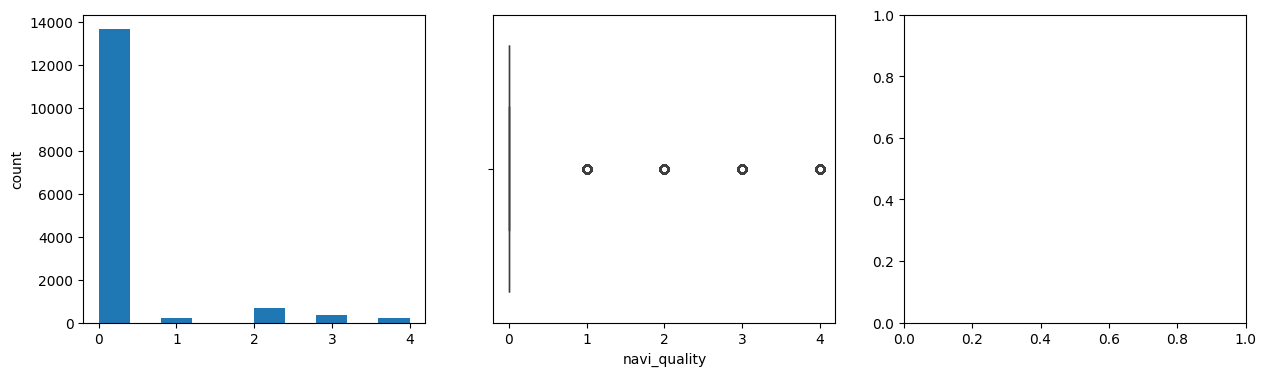

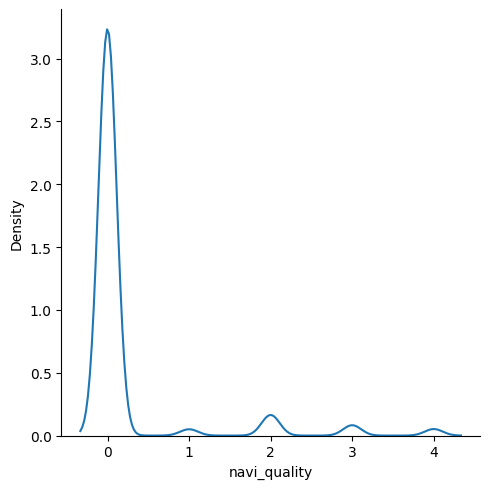

state
Skew : 1.03


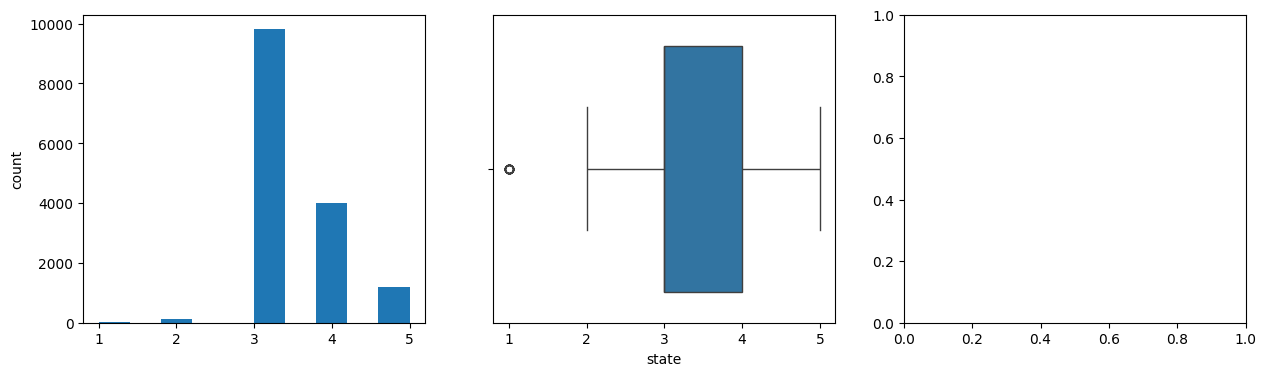

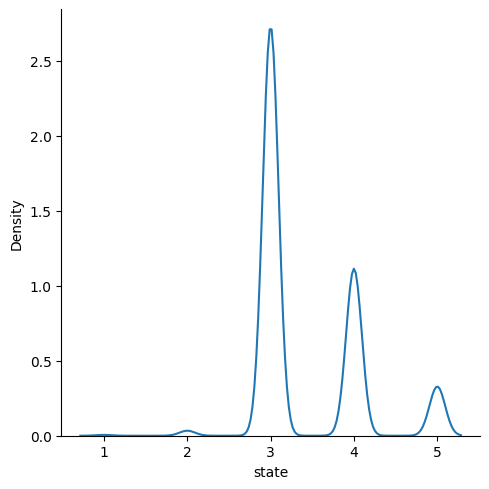

overall_quality
Skew : 0.79


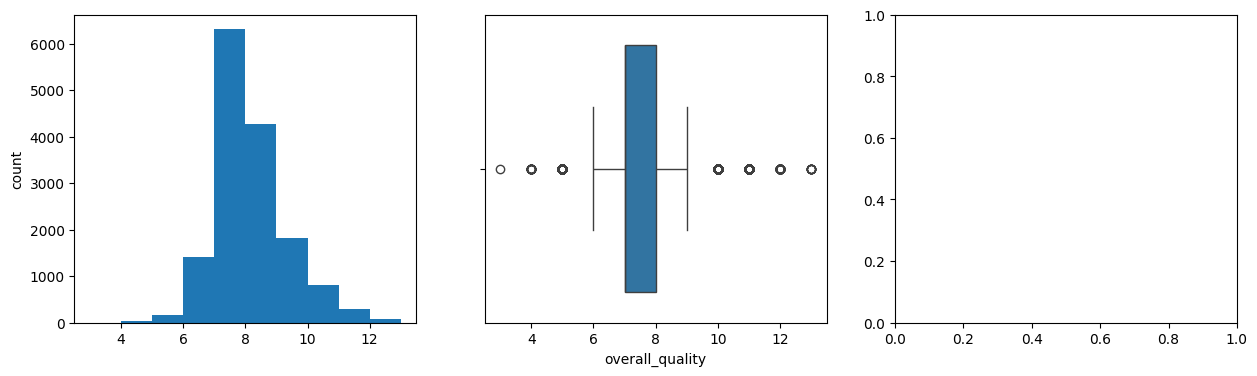

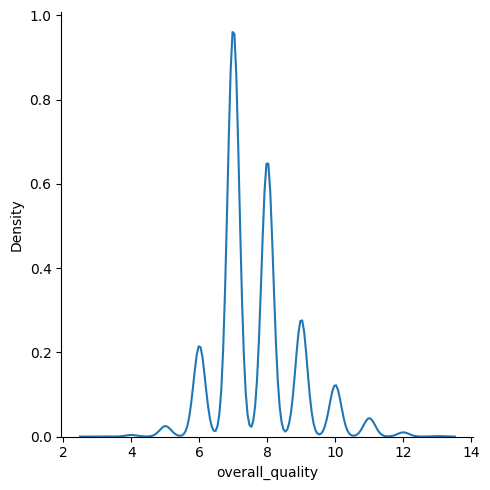

created_age
Skew : 0.48


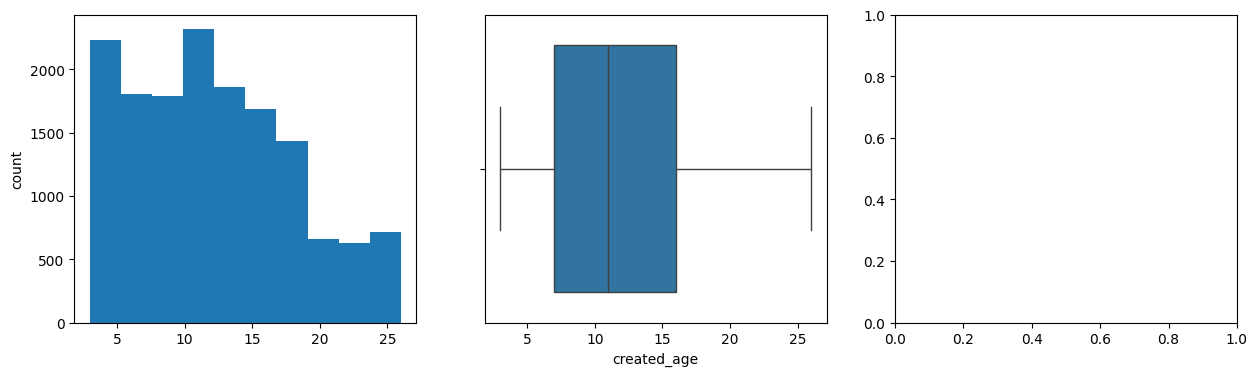

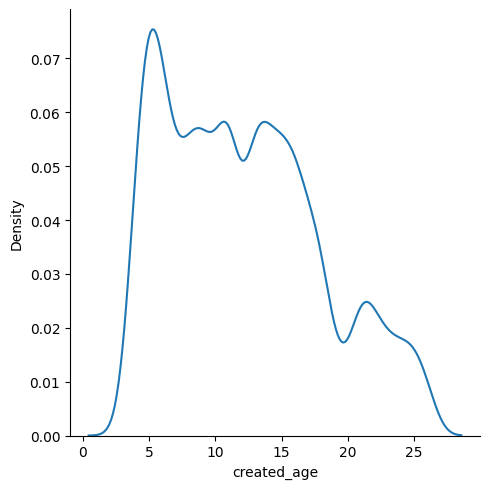

refitted_age
Skew : 0.57


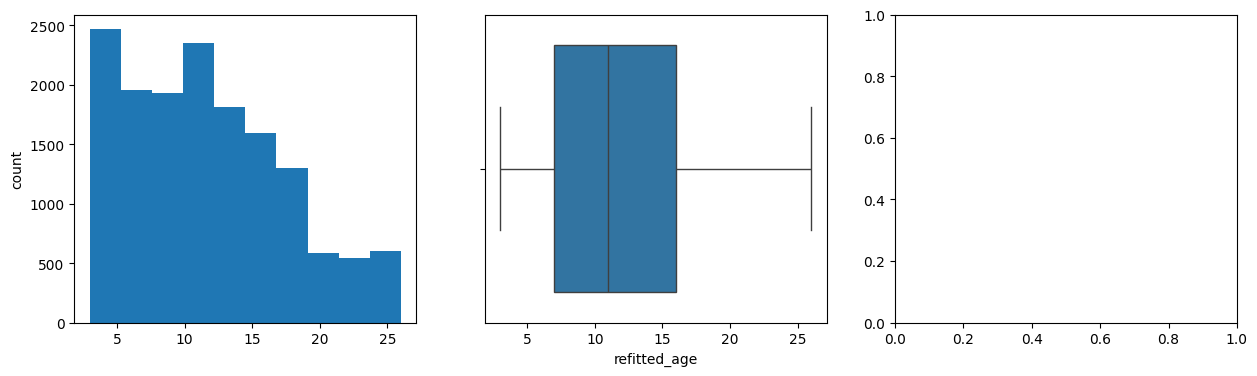

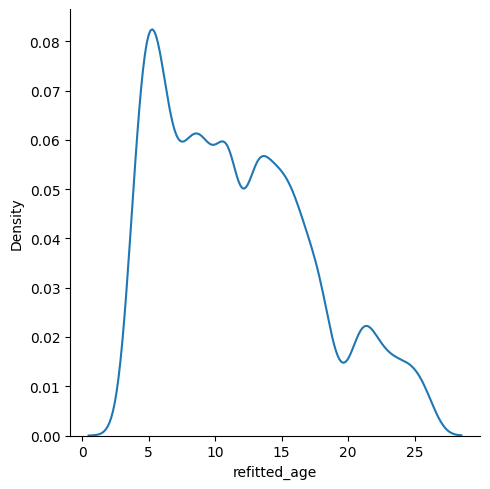

sale_age
Skew : 3.37


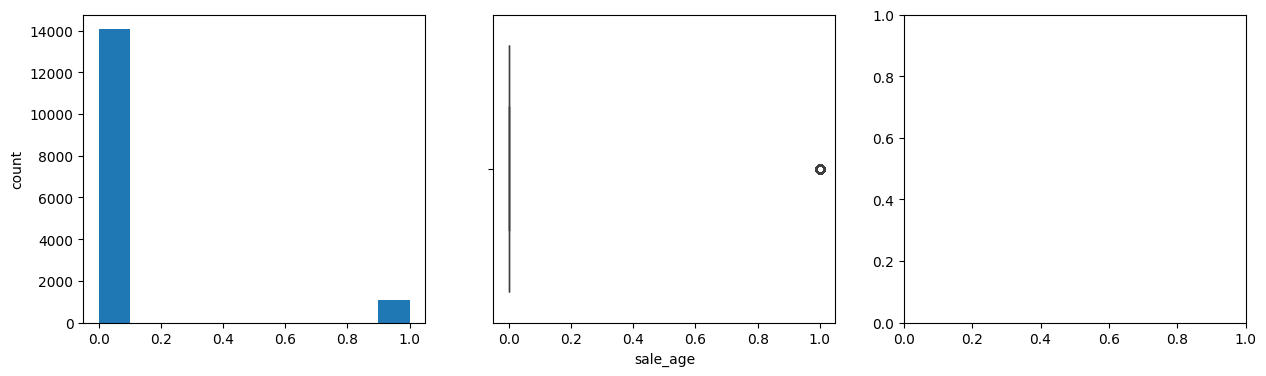

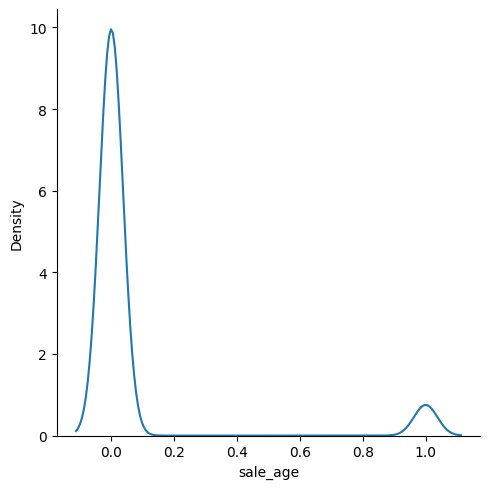

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dists(X):
    high_skews = []
    for col in X.select_dtypes(include=['float64','int64']).columns:
        print(col)
        data = X[col]
        skew = round(data.skew(), 2)
        print('Skew :', skew)
        if abs(skew) > 0.8:
            high_skews.append(col)
        plt.figure(figsize = (15, 4))
        plt.subplot(1, 3, 1)
        data.hist(grid=False)
        plt.ylabel('count')
        plt.subplot(1, 3, 2)
        sns.boxplot(x=data)
        plt.subplot(1, 3, 3)
        sns.displot(x=data, kind="kde")
        # sns.displot(ld.train_data, x=col, hue="price", kind="kde", fill=True)
        # sns.jointplot(data=ld.train_data, x=col, y="price")
        plt.show()
    return high_skews

high_skews = plot_dists(ld.X)

sale_date
Skew : 0.18


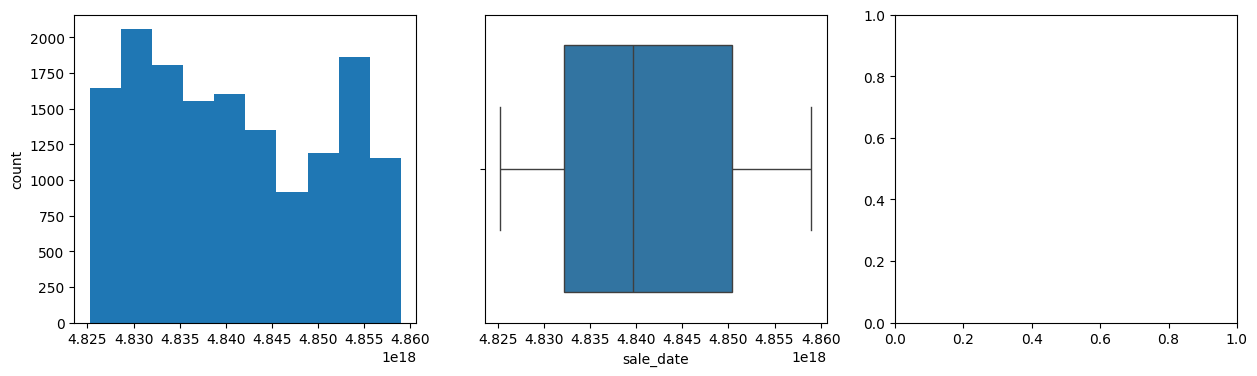

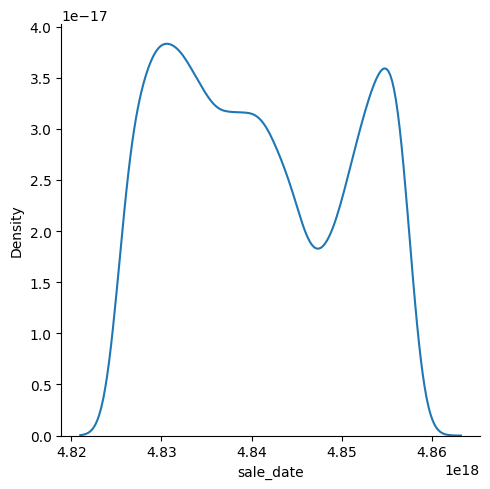

sale_age
Skew : 3.37


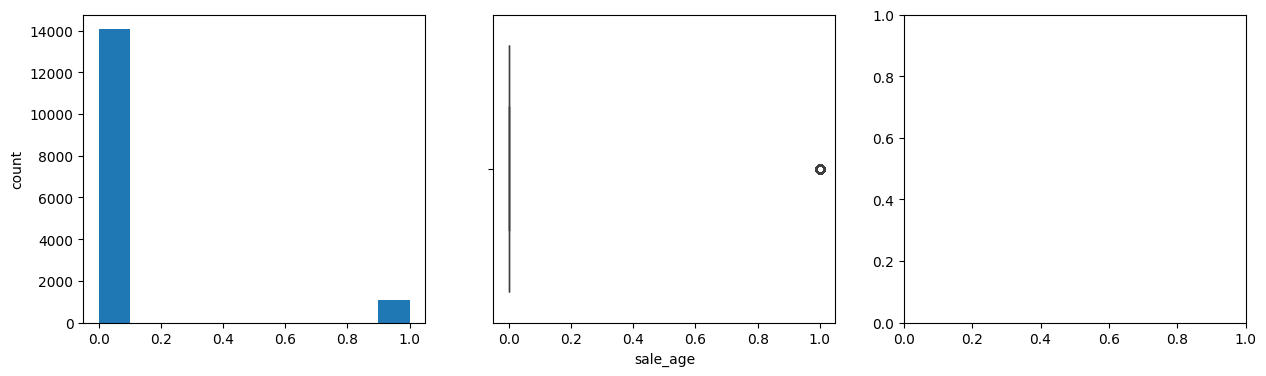

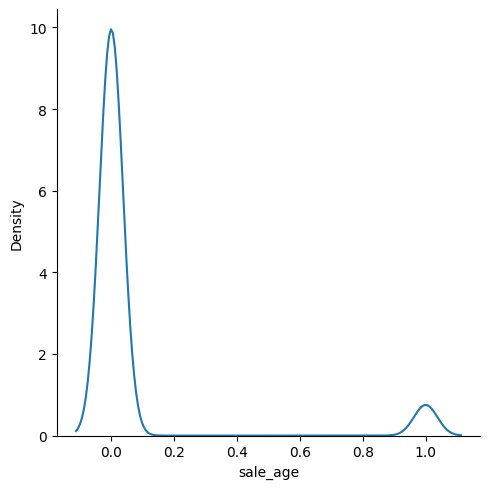

refitted_date
Skew : -0.57


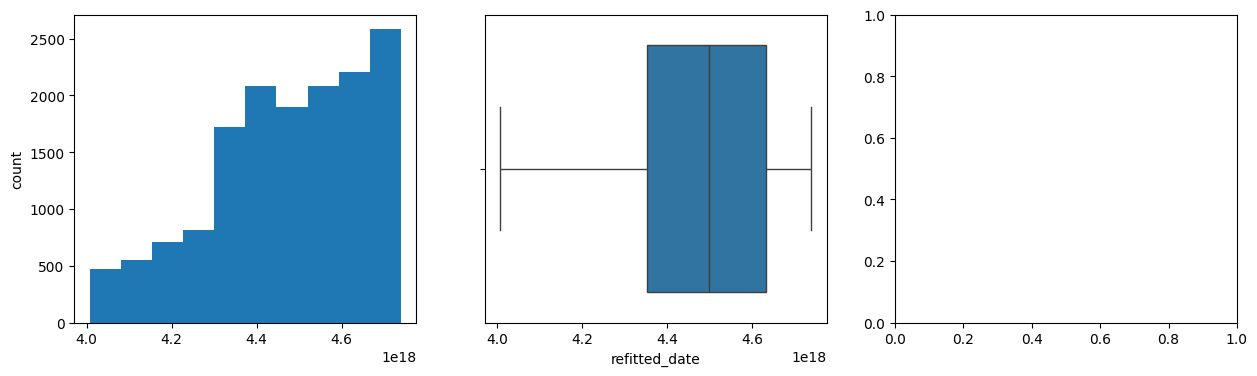

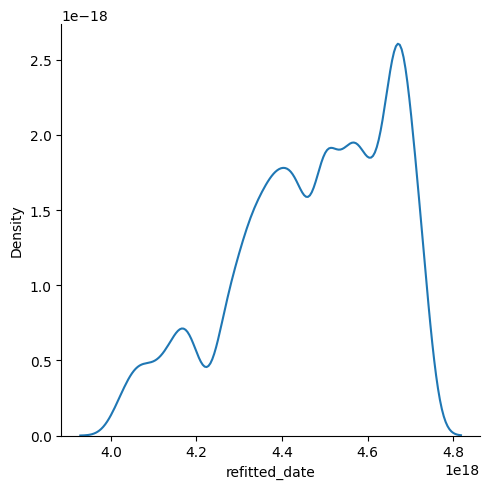

refitted_date
Skew : -0.57


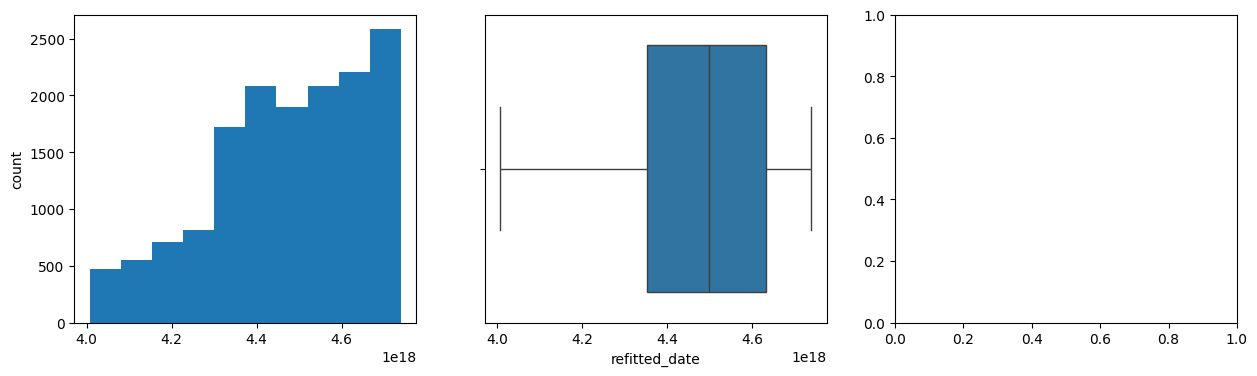

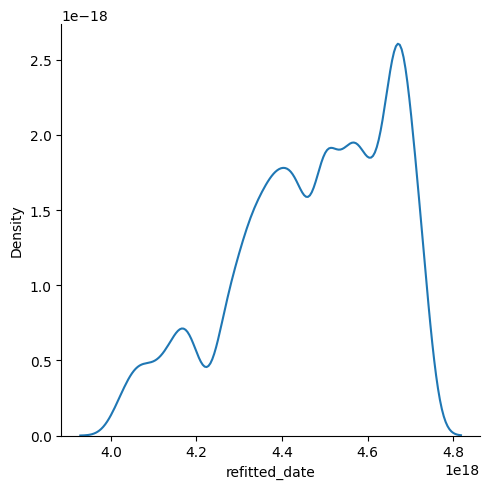

created_date
Skew : -0.48


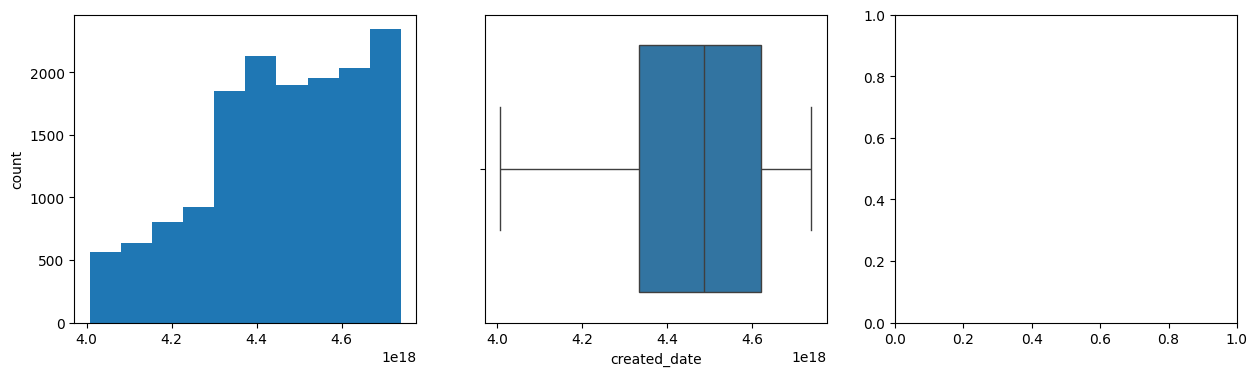

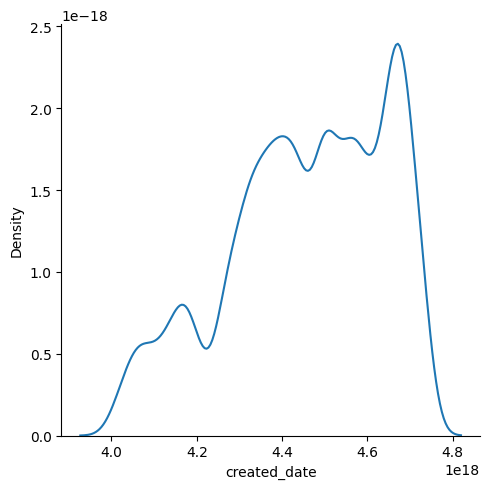

created_age
Skew : 0.48


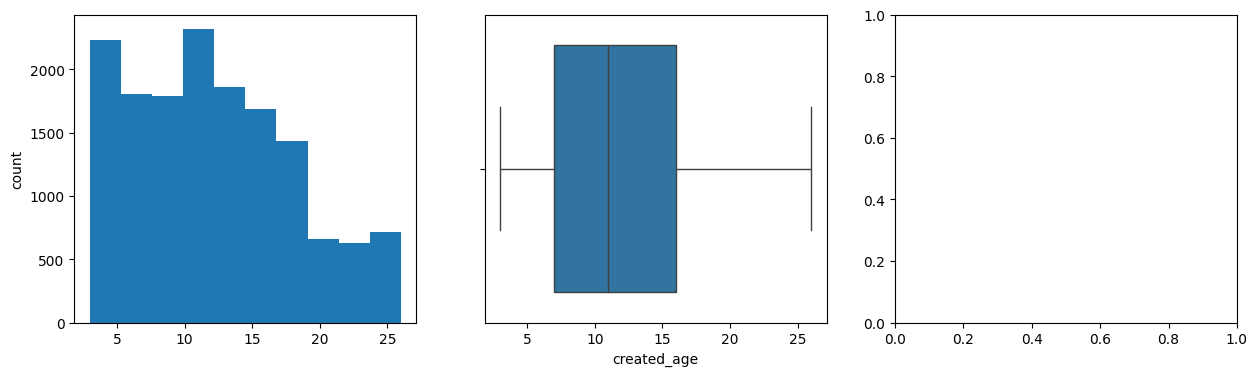

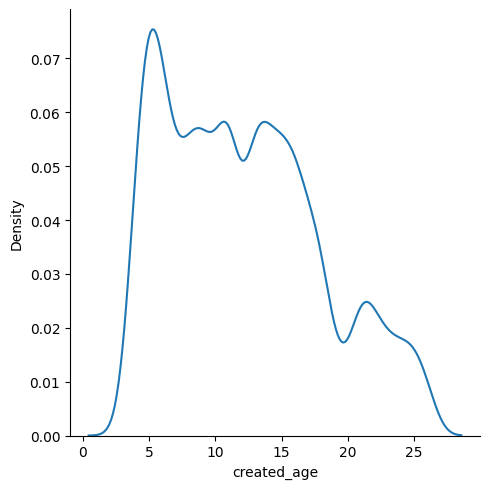

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in ld.X[['sale_date', 'sale_age', 'refitted_date', 'refitted_date', 'created_date', 'created_age']].select_dtypes(include=['float64','int64']).columns:
    print(col)
    data = ld.X[col]
    print('Skew :', round(data.skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 3, 1)
    data.hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 3, 2)
    sns.boxplot(x=data)
    plt.subplot(1, 3, 3)
    # sns.distplot(data, axlabel="Dist");
    sns.displot(x=data, kind="kde")
    # plt.subplot(2, 3, 3)
    # sns.displot(ld.train_data, x=col, hue="price", kind="kde", fill=True)
    # sns.jointplot(data=ld.train_data, x=col, y="price")
    plt.show()


cabins
Skew : 2.52


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


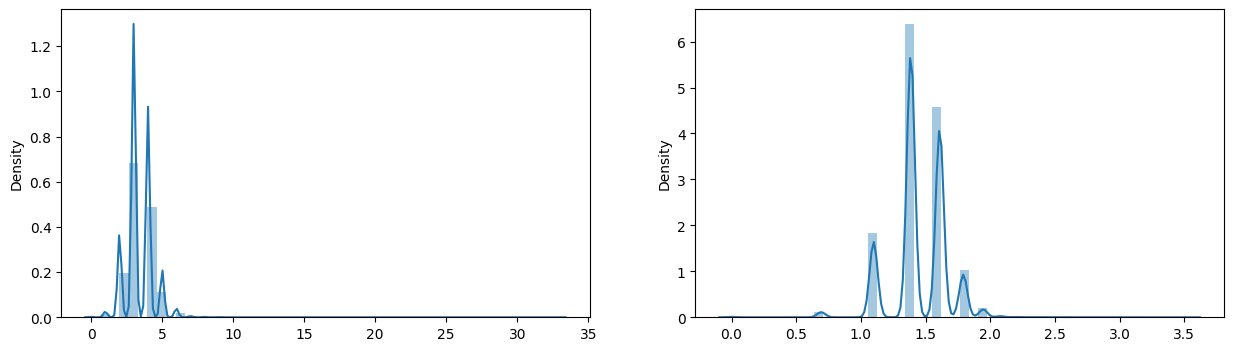

decks
Skew : 0.61


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


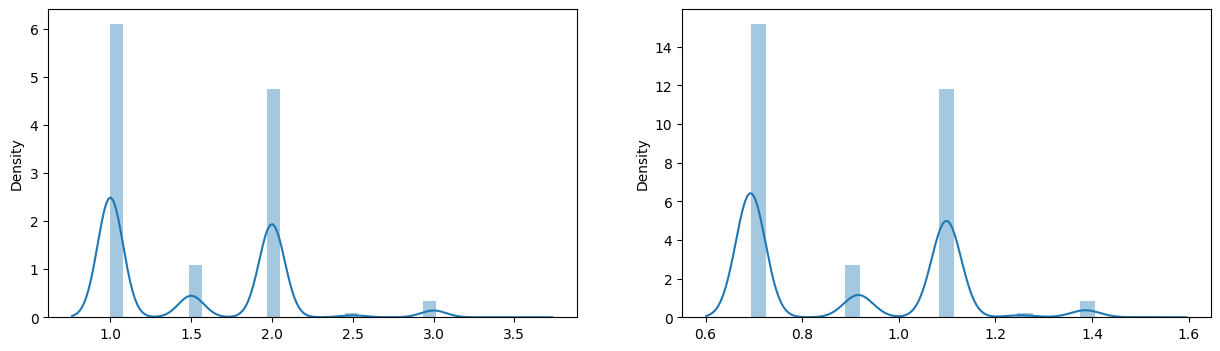

bathrooms
Skew : 0.93


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


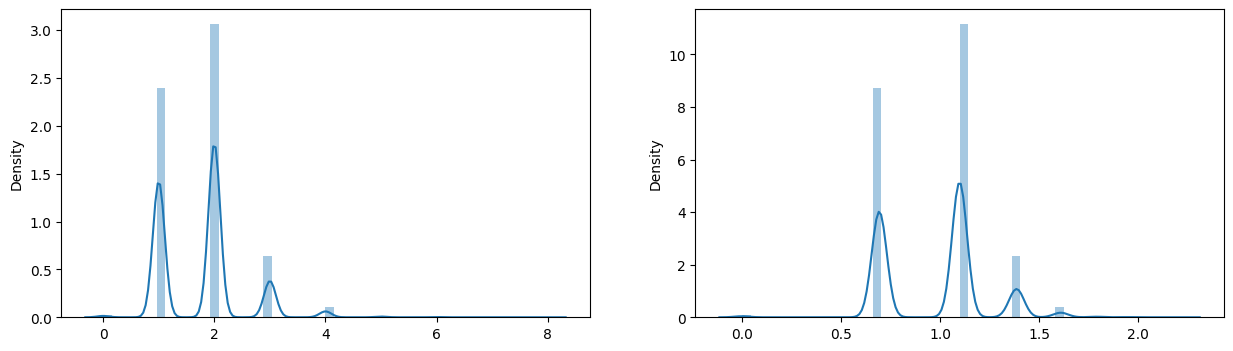

total_area
Skew : 13.38


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


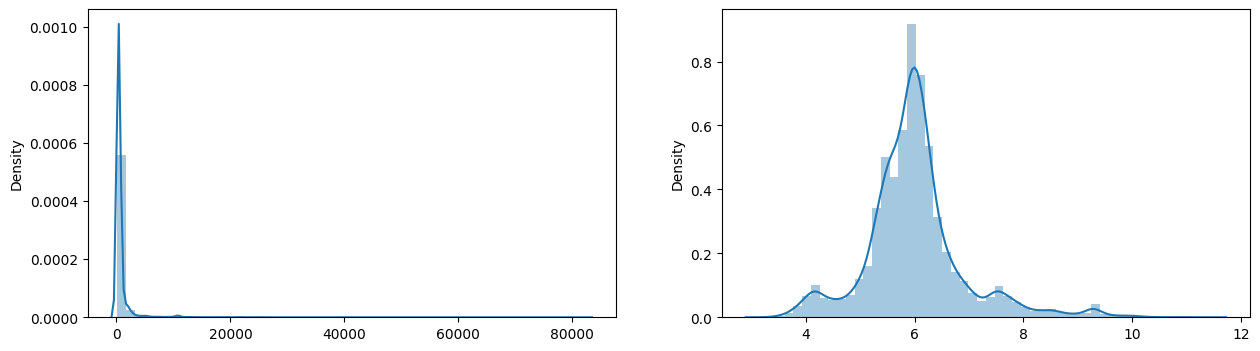

crew_area
Skew : 1.5


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


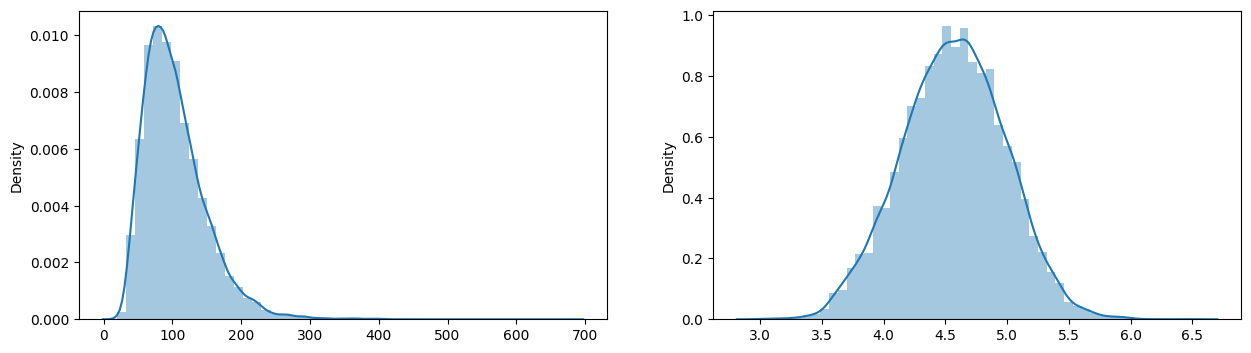

cabins_area
Skew : 1.45


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


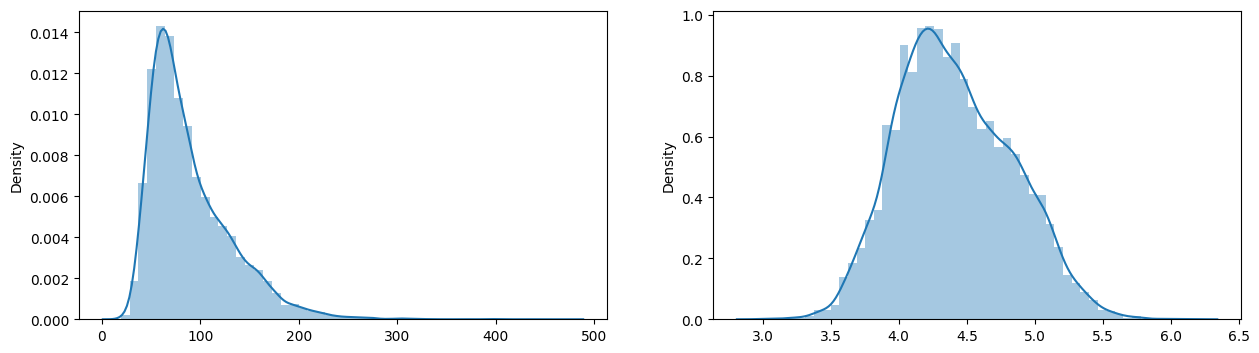

maintenance_area
Skew : 1.58


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


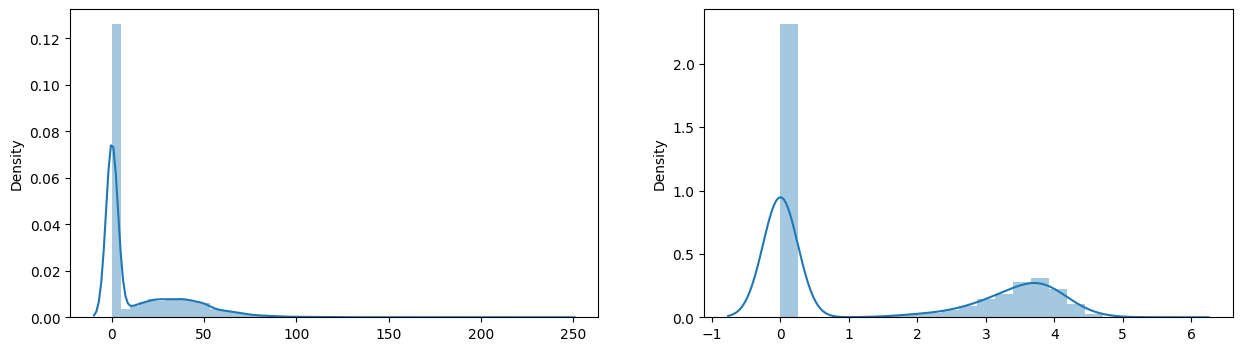

crew_area_coef
Skew : 1.11


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


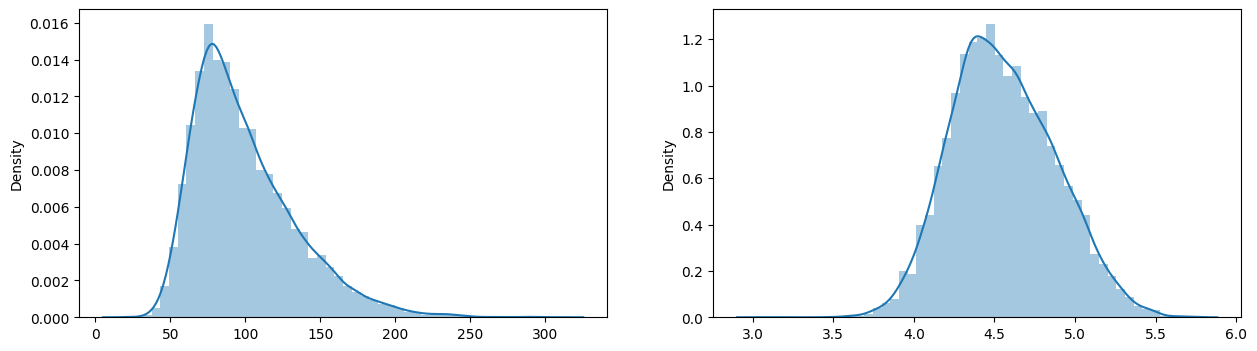

total_area_coef
Skew : 8.83


/tmp/ipykernel_1245302/4043503968.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data)
/tmp/ipykernel_1245302/4043503968.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=log_transform(data))


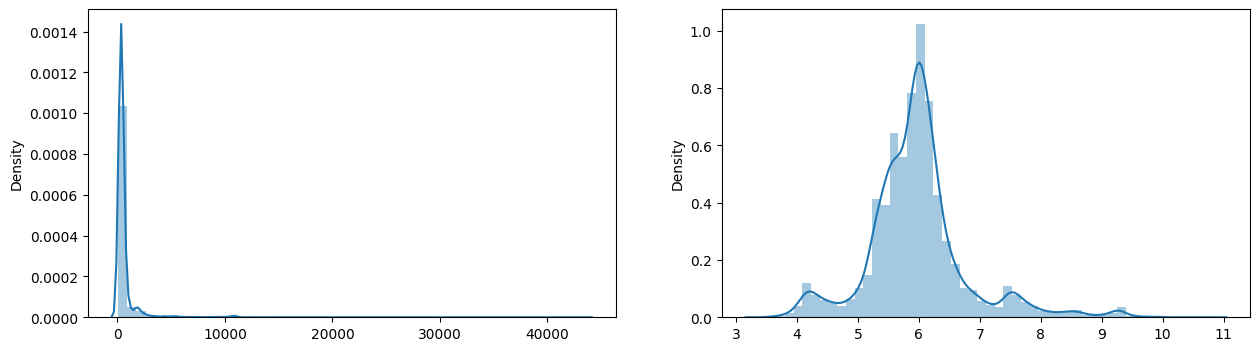

id
Skew : 0.0


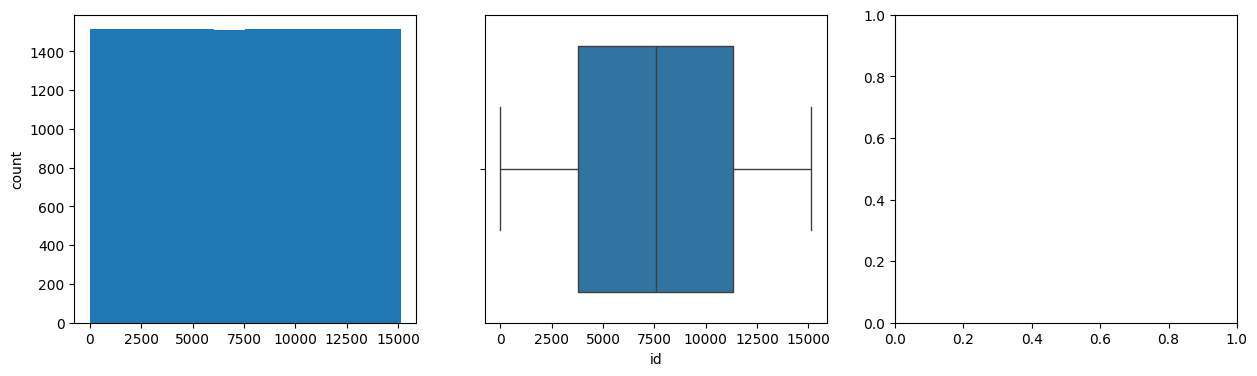

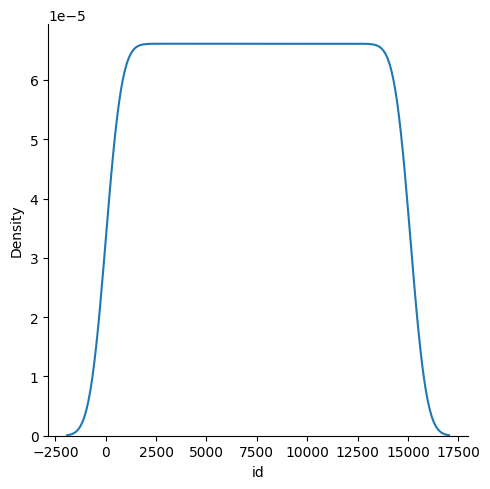

sale_date
Skew : 0.18


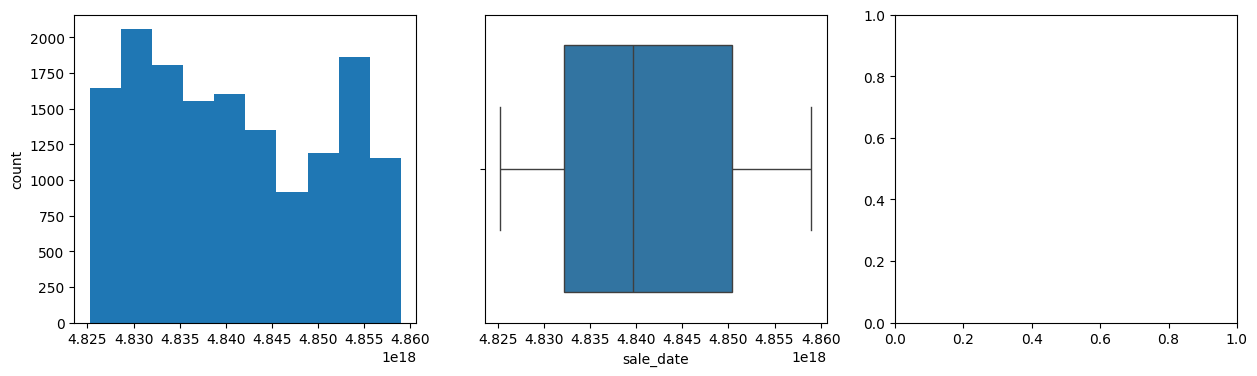

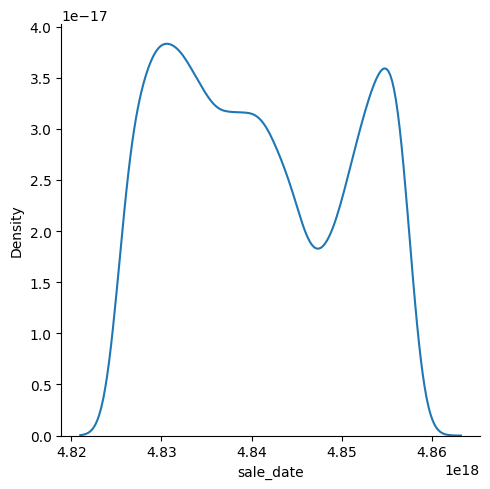

cabins
Skew : 2.52


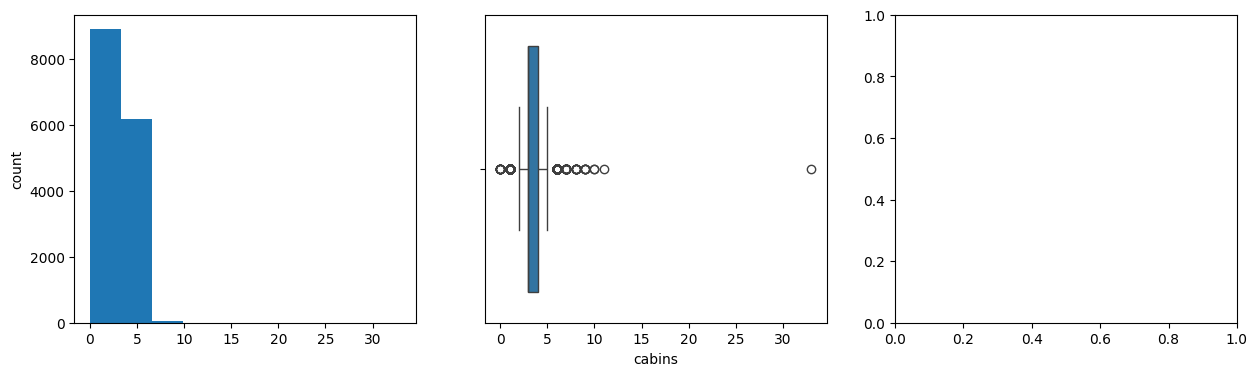

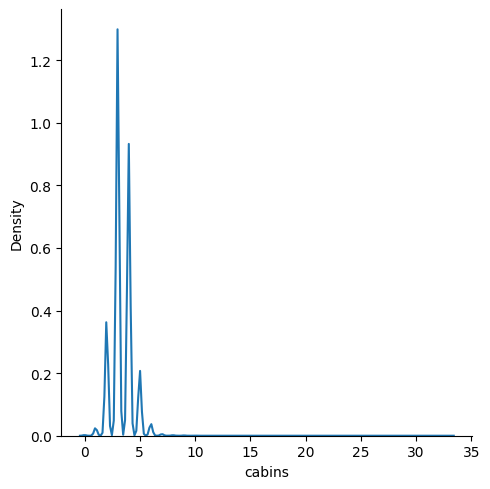

decks
Skew : 0.61


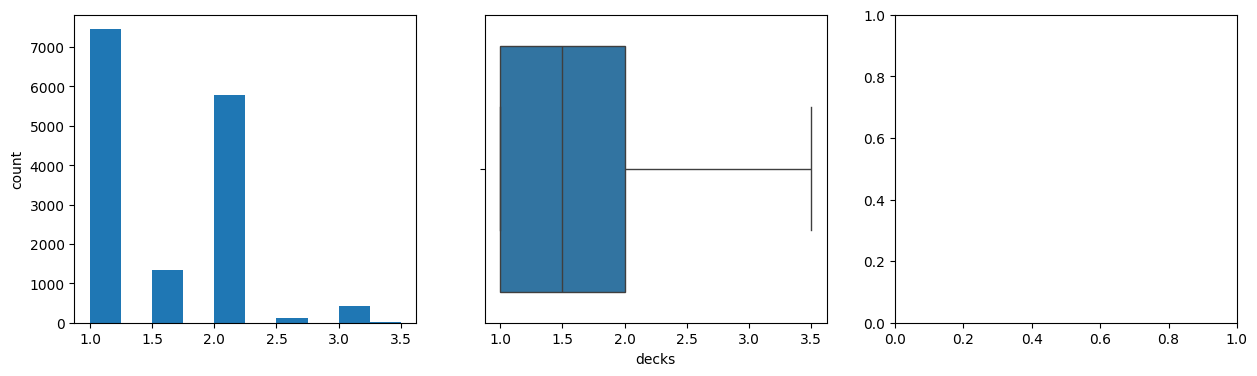

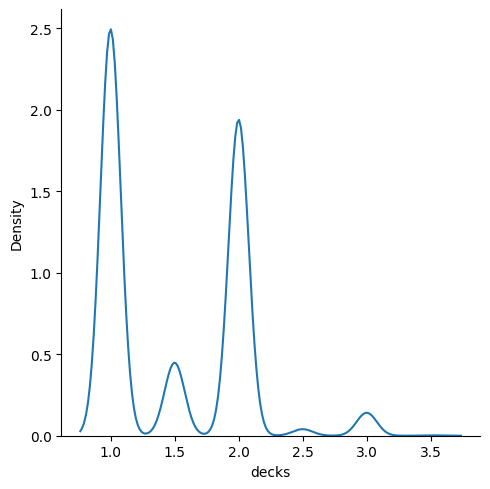

bathrooms
Skew : 0.93


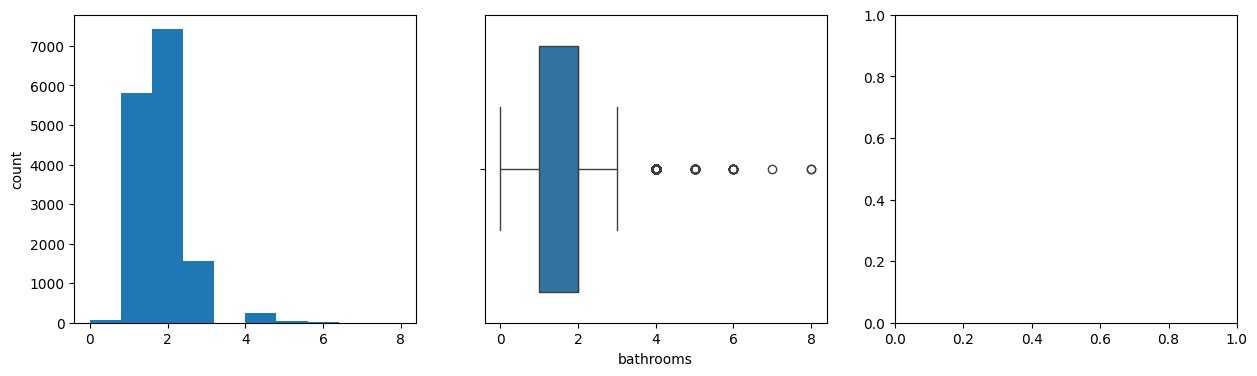

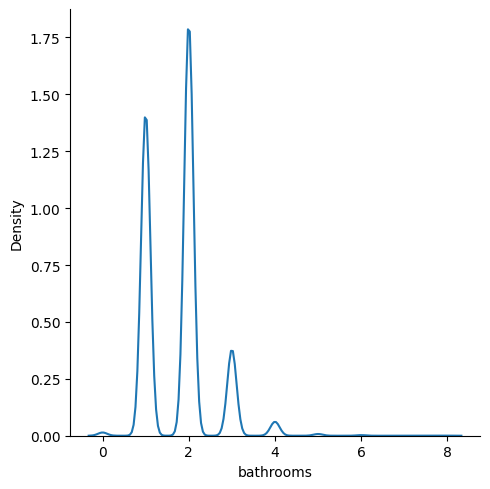

producer
Skew : -0.05


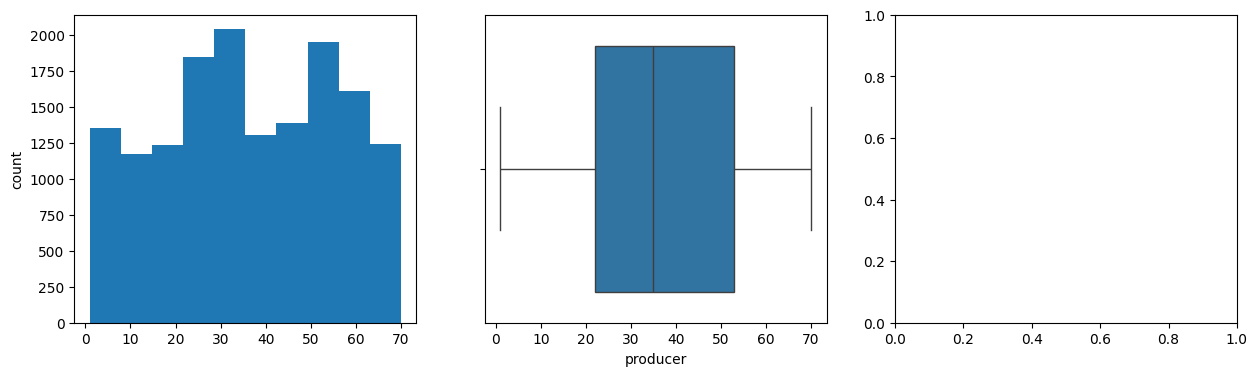

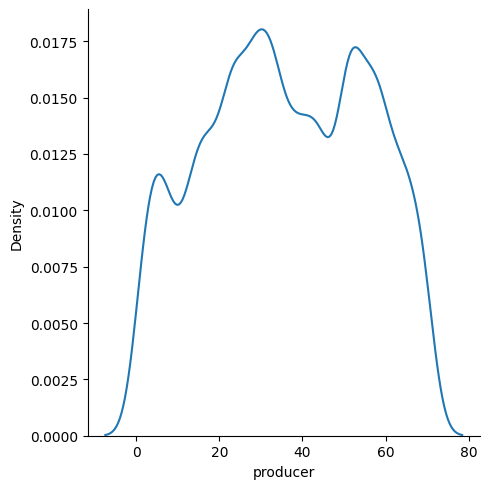

created_date
Skew : -0.48


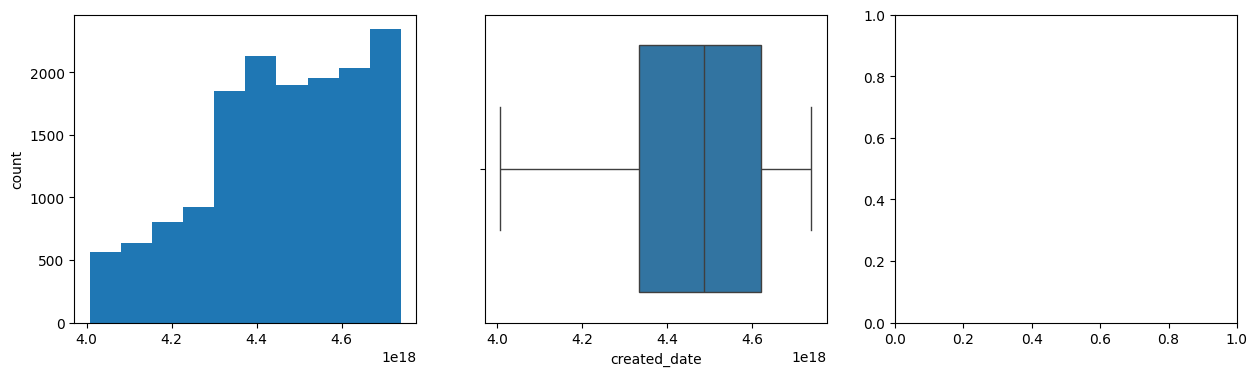

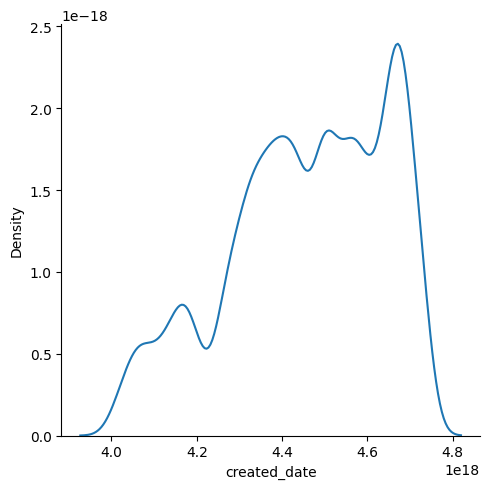

refitted_date
Skew : -0.57


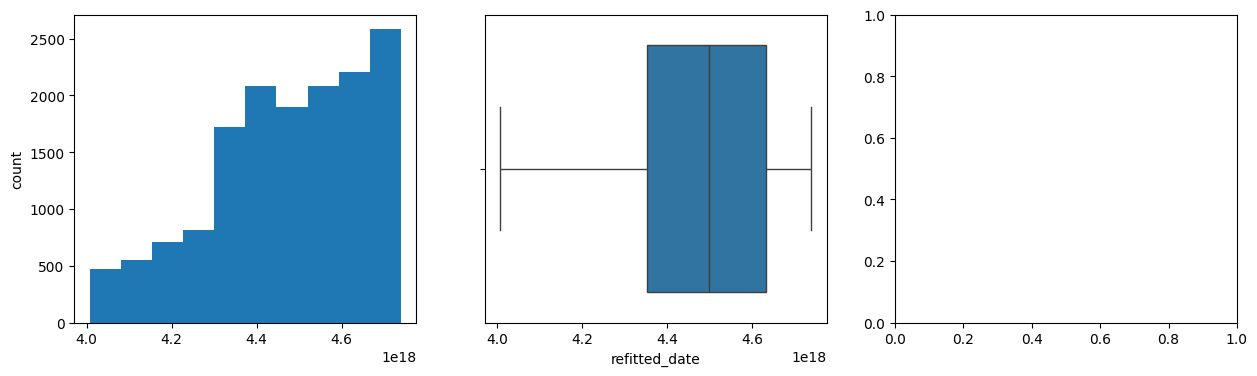

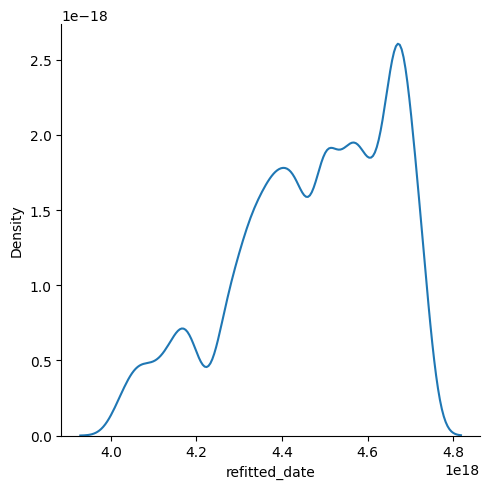

total_area
Skew : 13.38


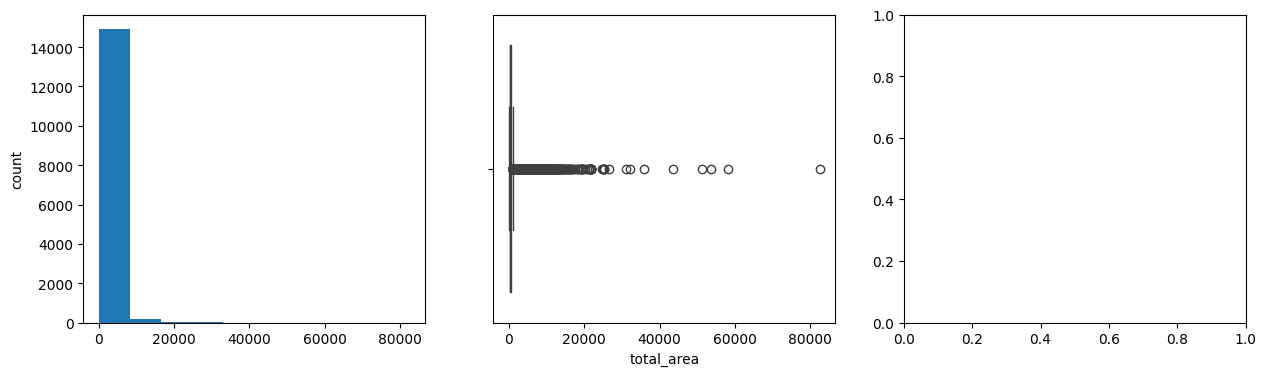

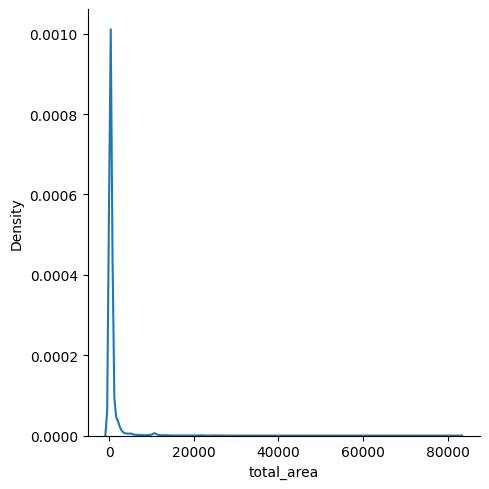

crew_area
Skew : 1.5


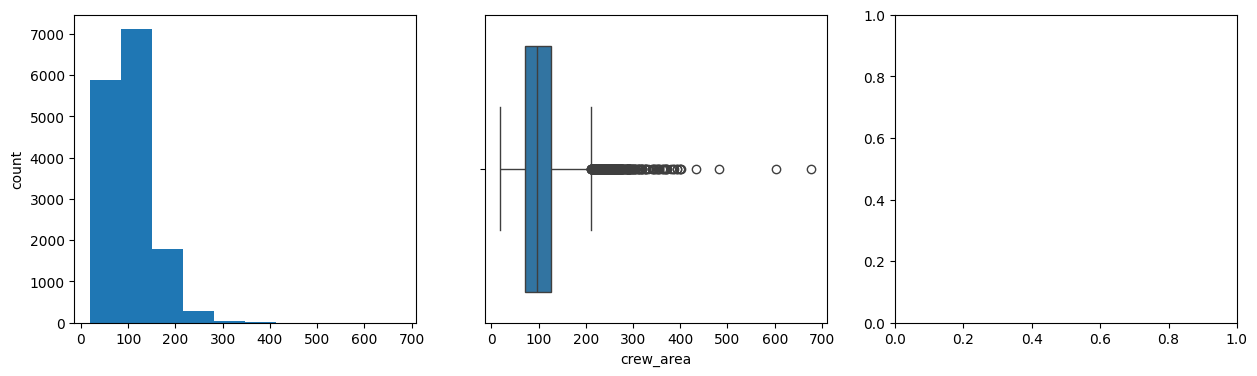

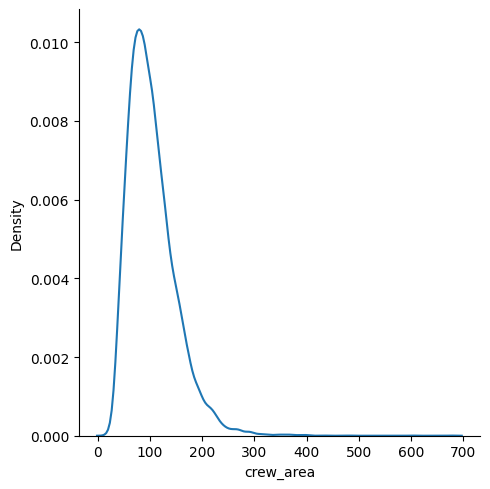

cabins_area
Skew : 1.45


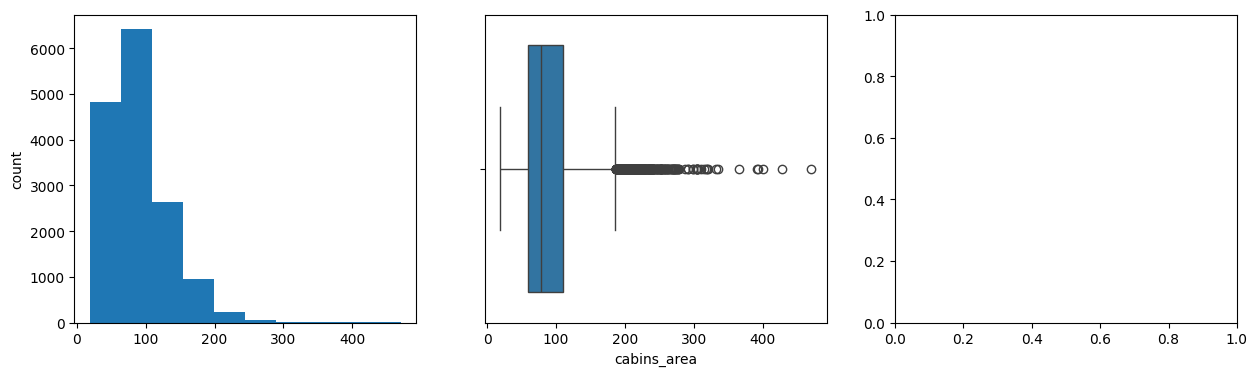

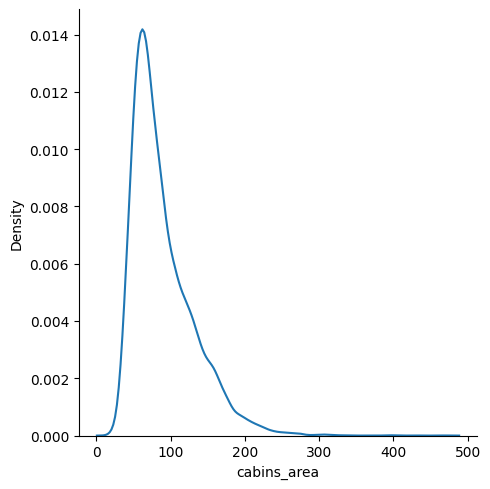

maintenance_area
Skew : 1.58


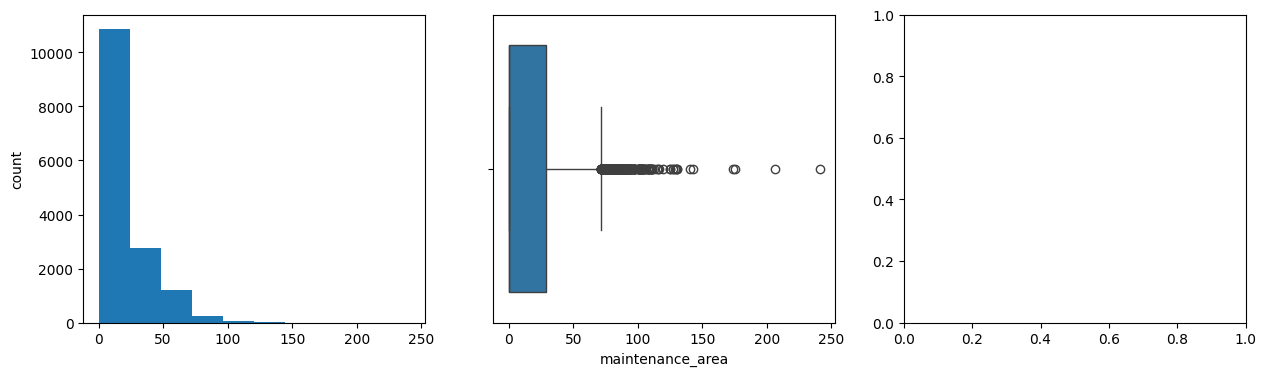

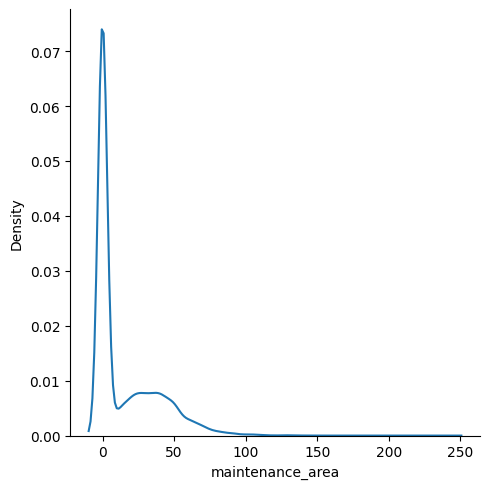

crew_area_coef
Skew : 1.11


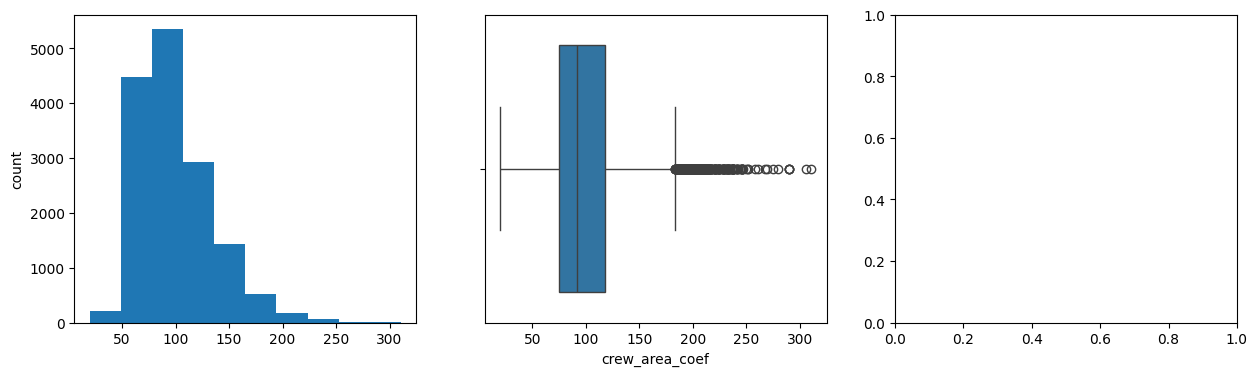

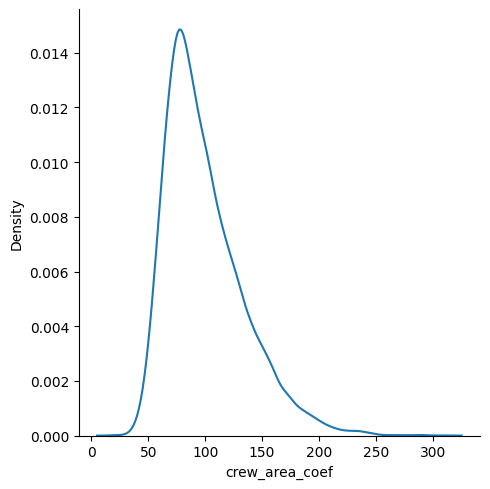

total_area_coef
Skew : 8.83


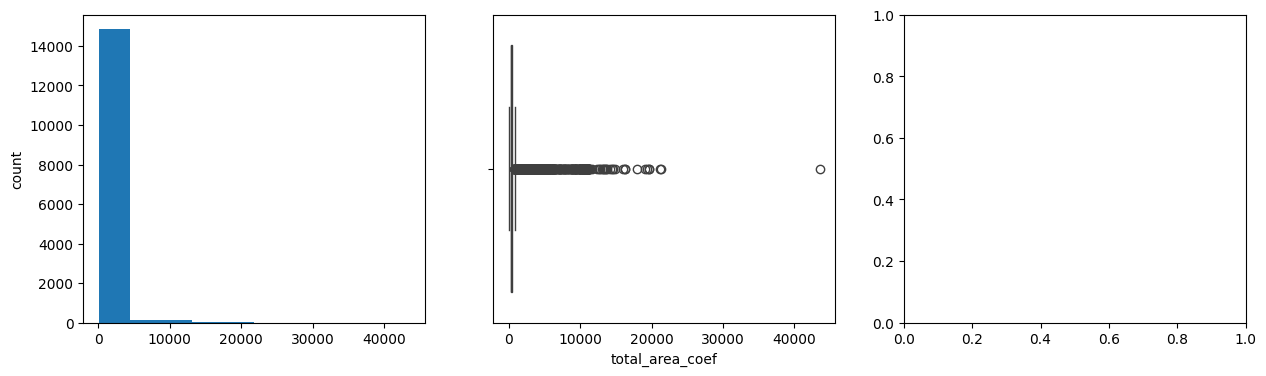

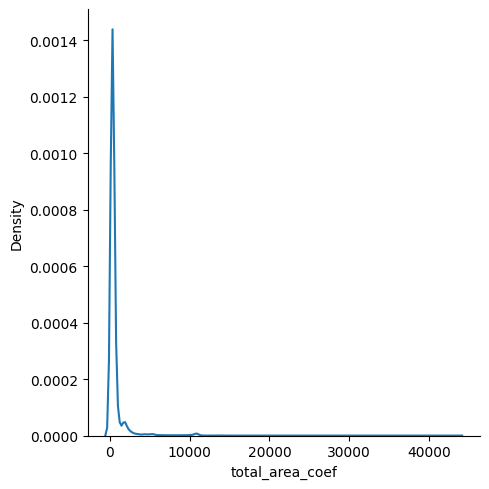

weight_distribution_x
Skew : 0.89


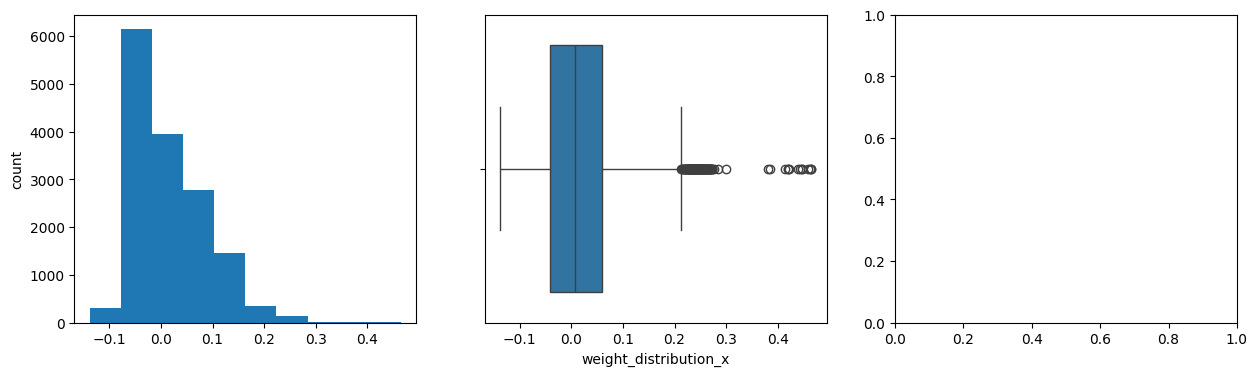

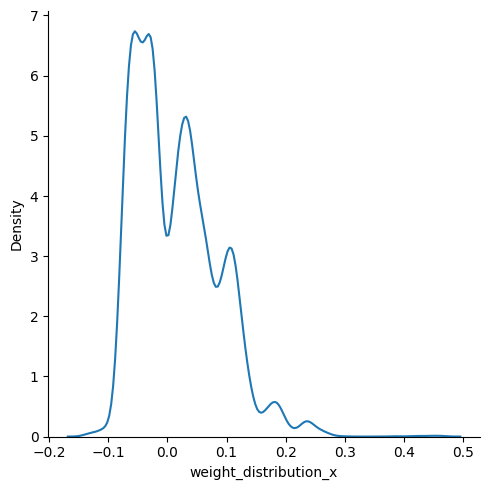

weight_distribution_y
Skew : 0.49


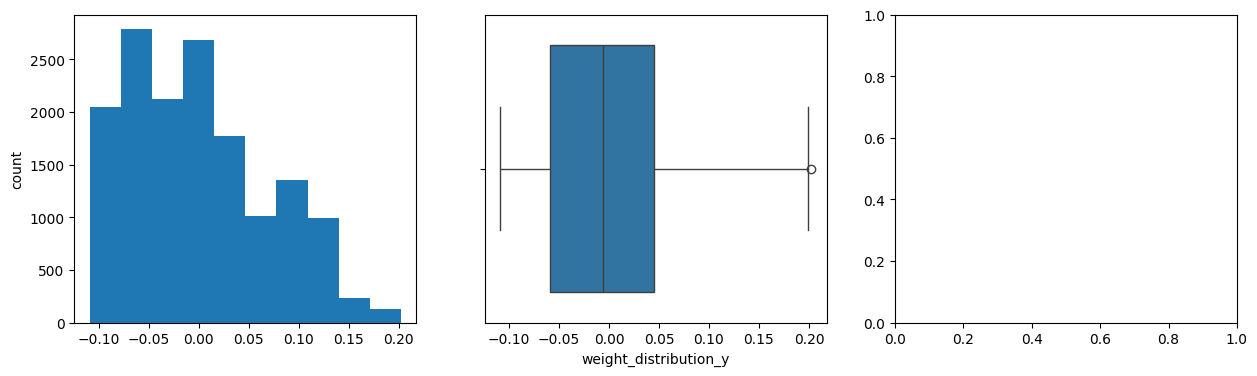

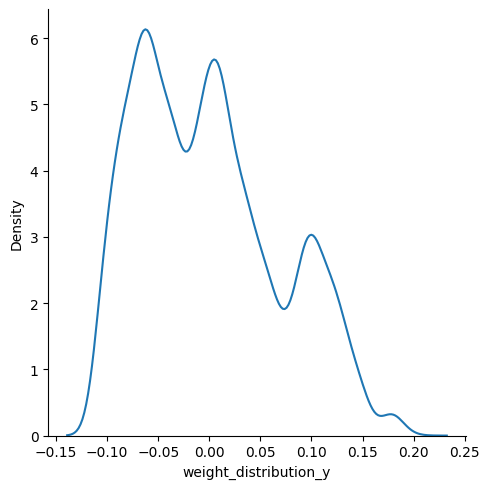

engine_thrust
Skew : 0.73


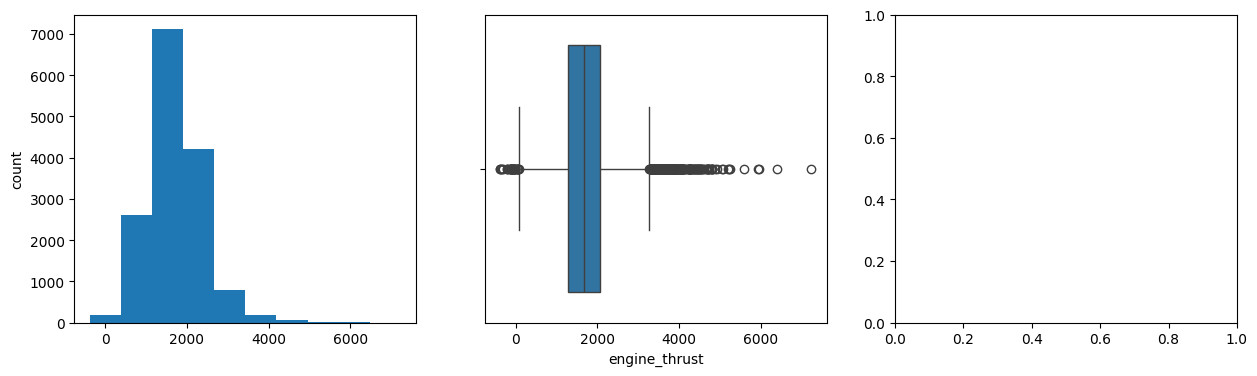

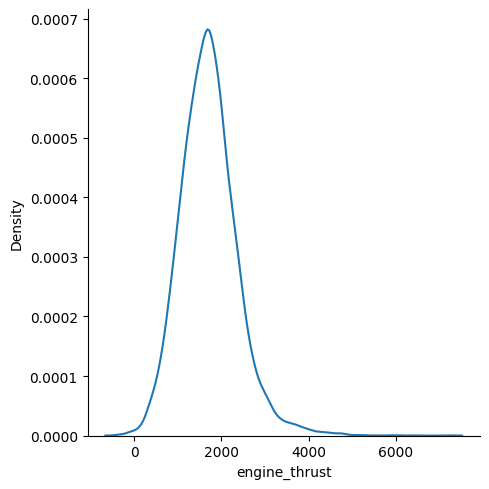

radar
Skew : 11.55


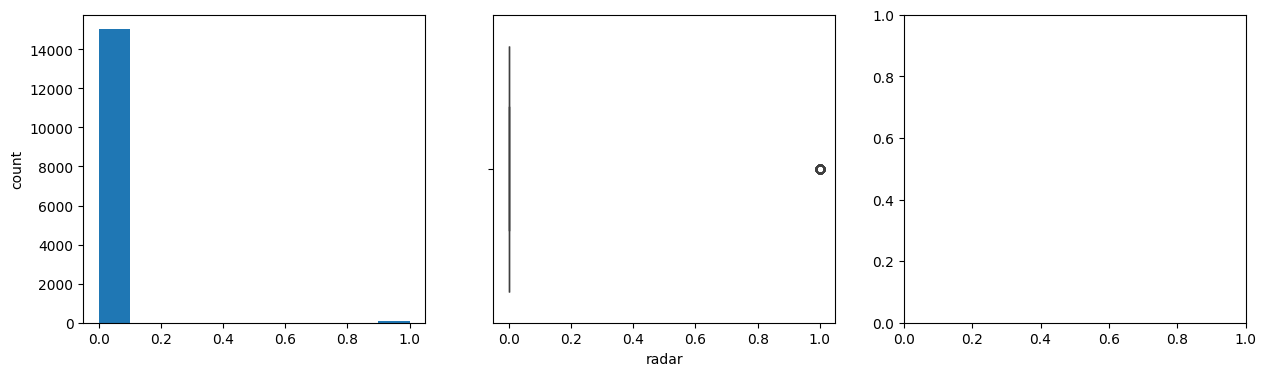

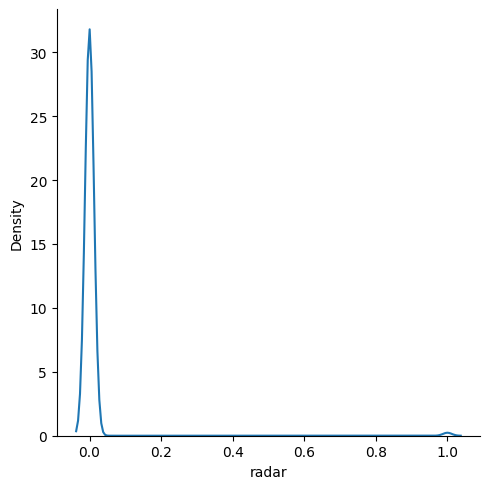

bow_thruster
Skew : 0.31


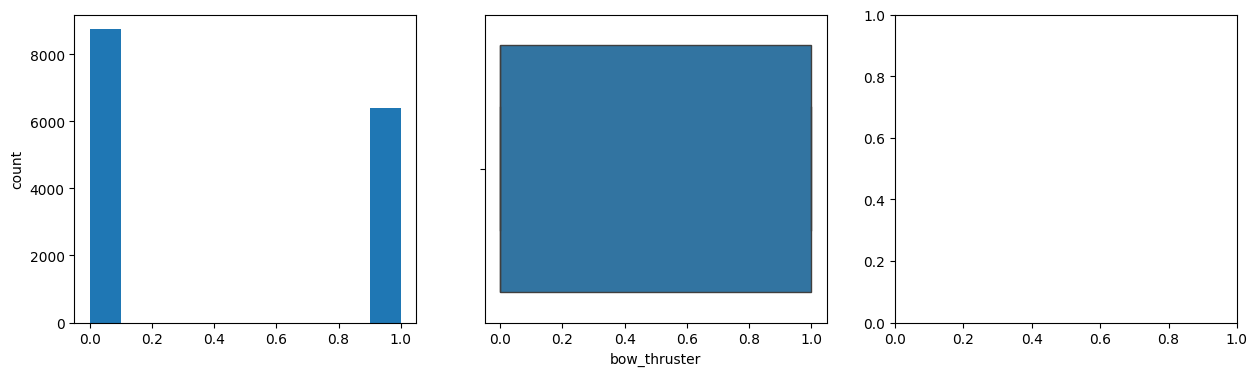

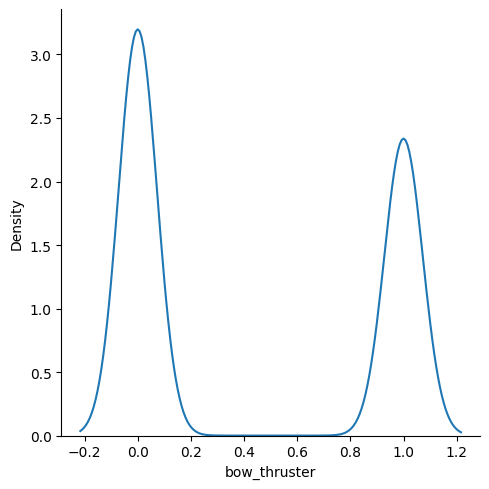

autopilot
Skew : -0.88


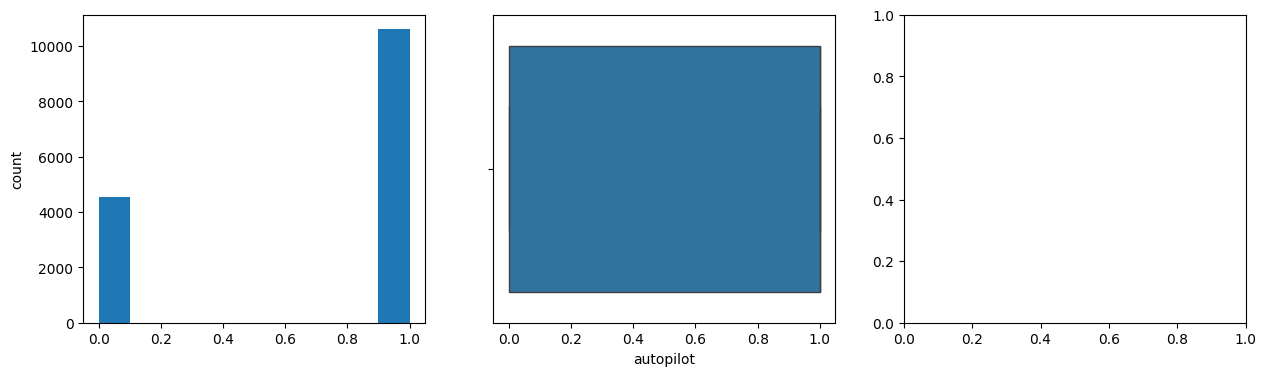

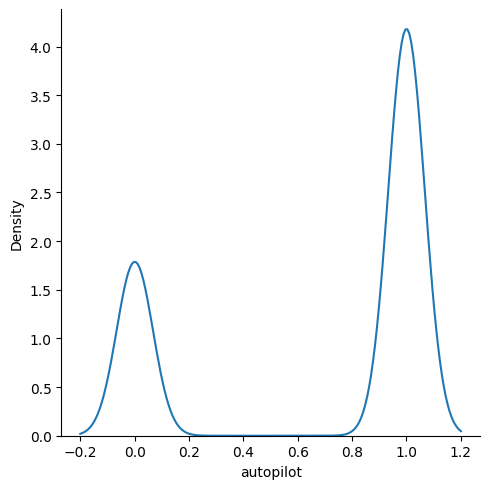

solar_panels
Skew : 8.44


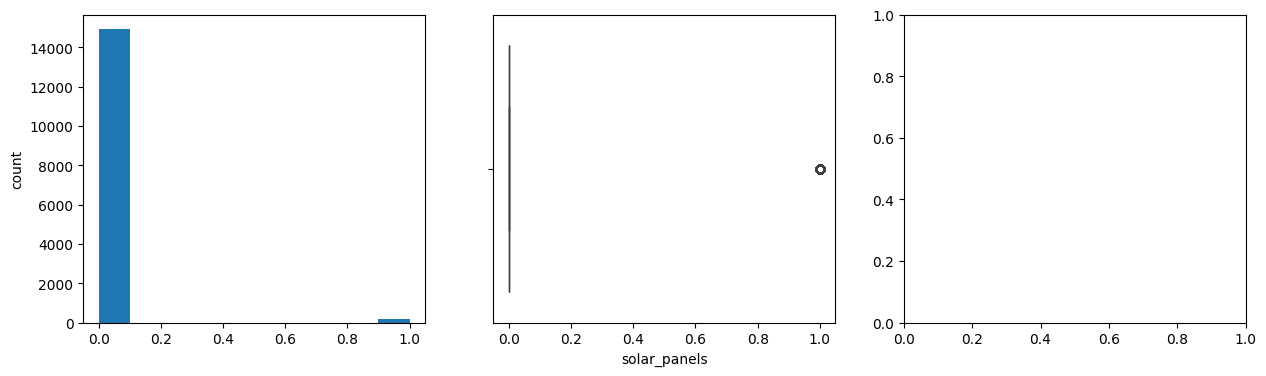

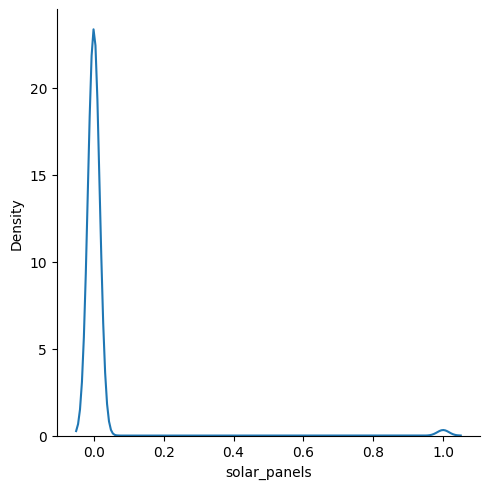

navi_quality
Skew : 3.4


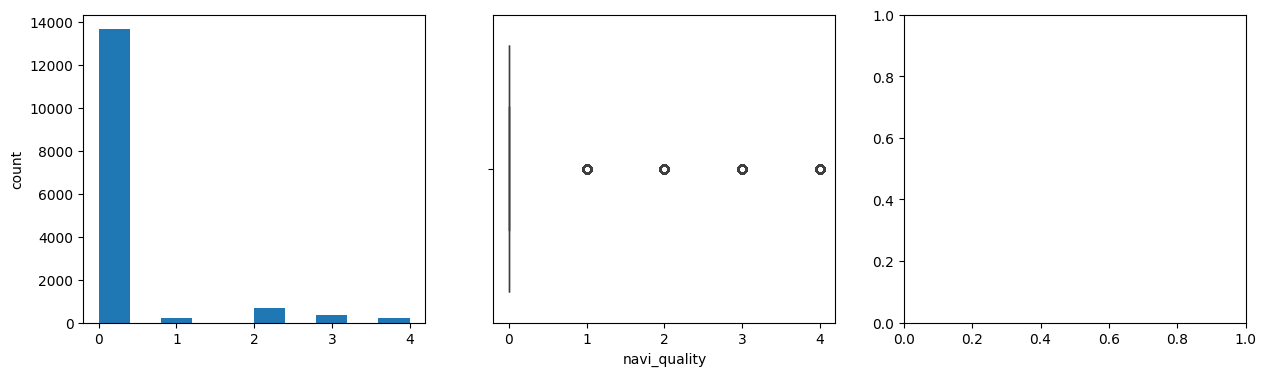

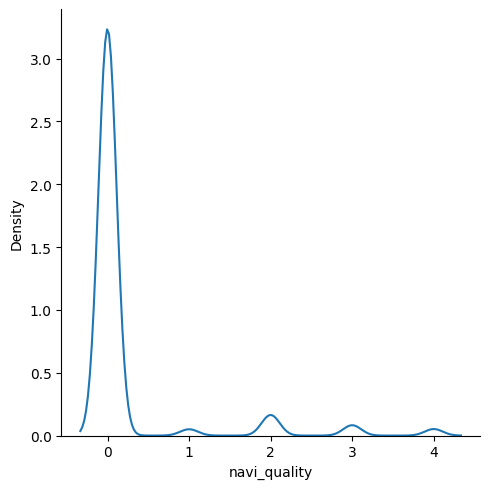

state
Skew : 1.03


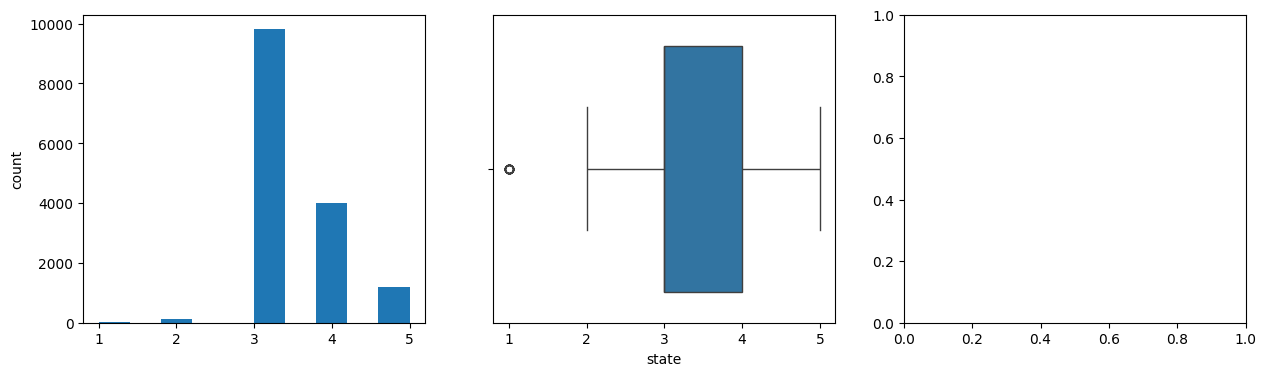

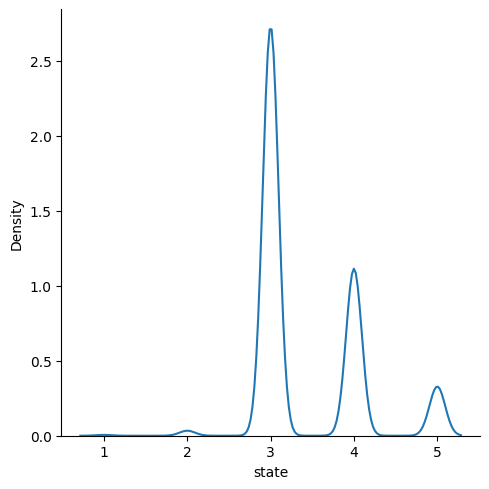

overall_quality
Skew : 0.79


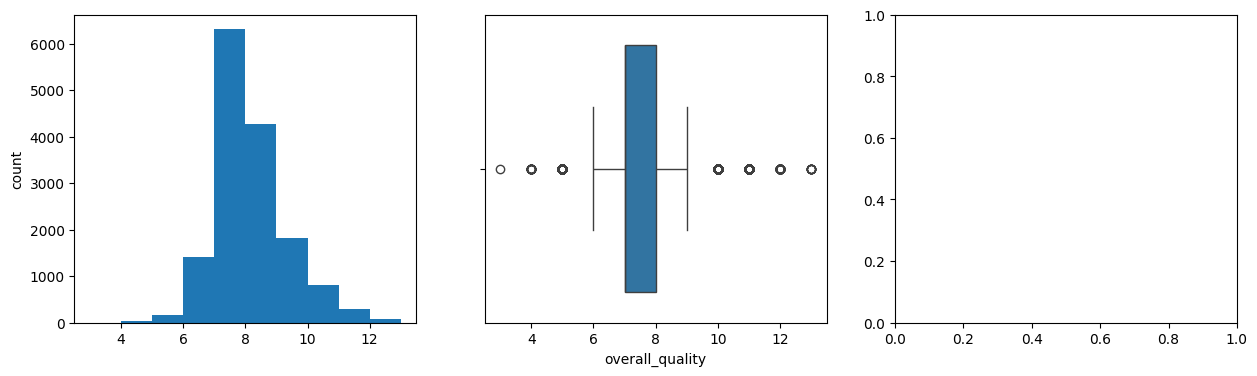

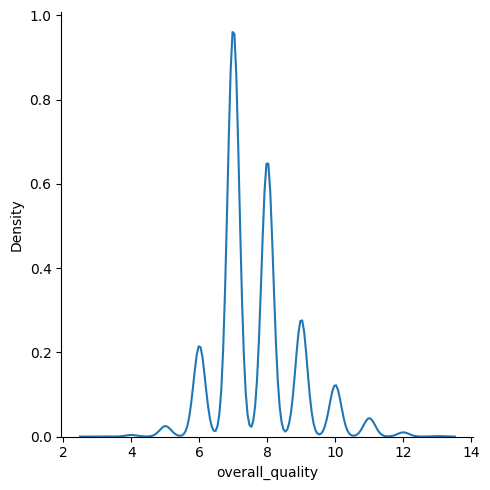

created_age
Skew : 0.48


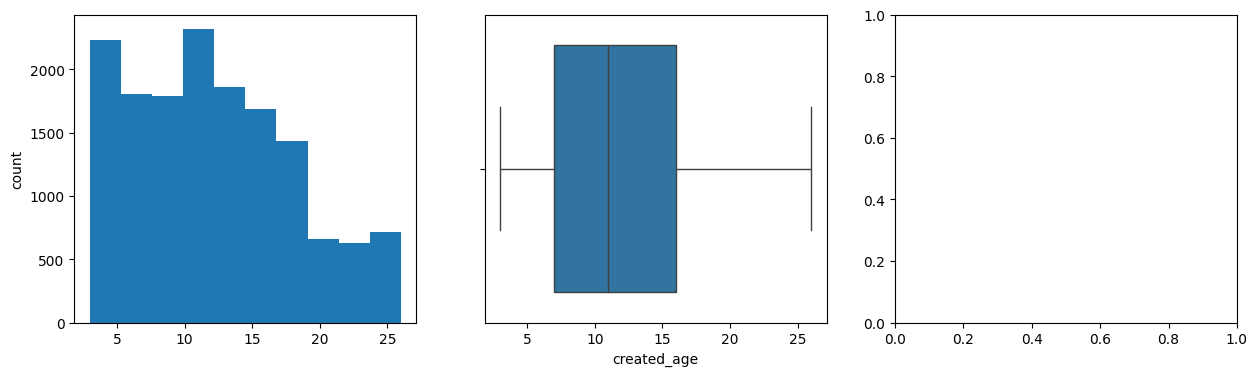

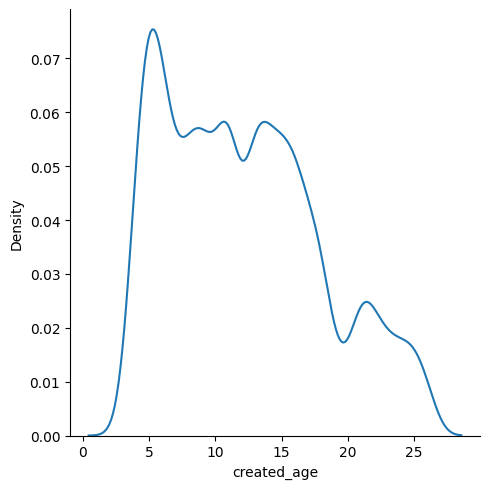

refitted_age
Skew : 0.57


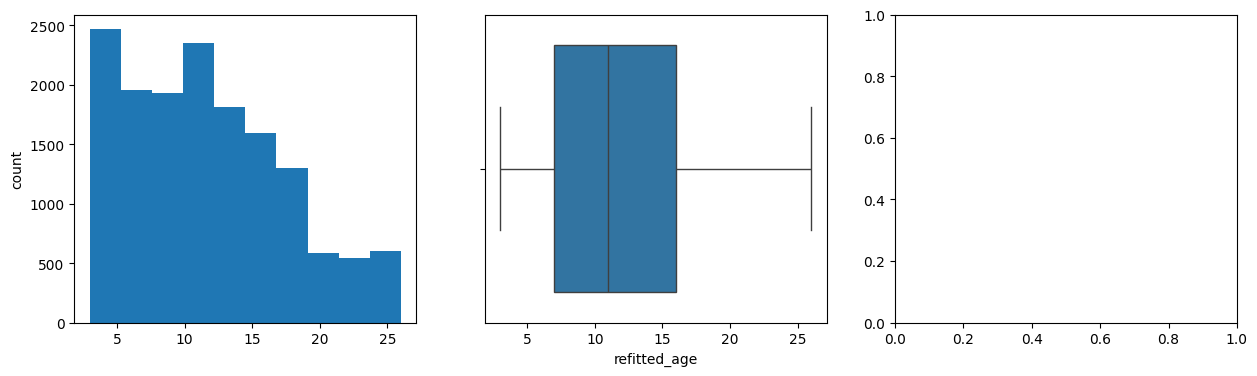

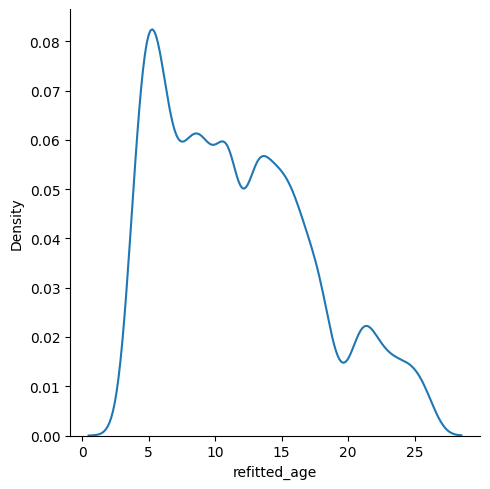

sale_age
Skew : 3.37


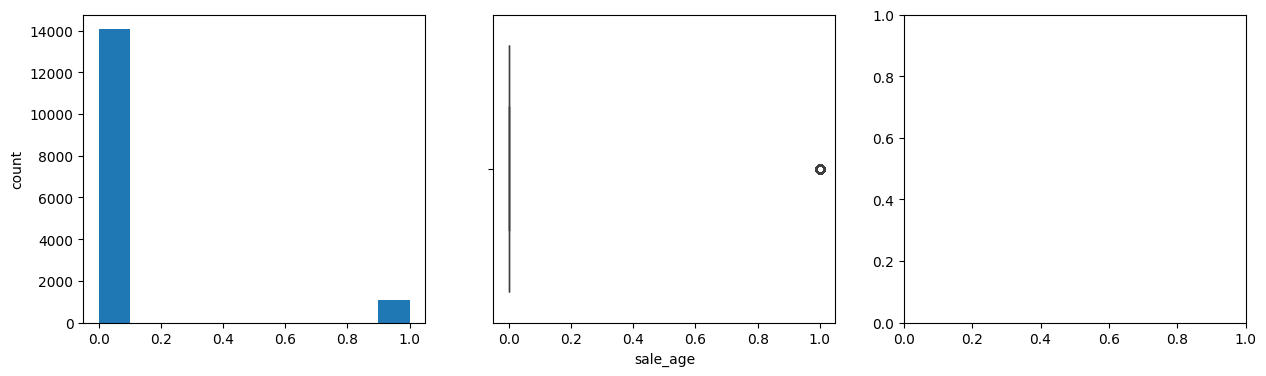

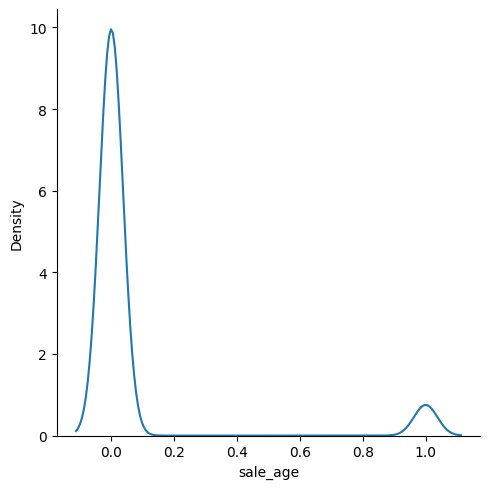

['cabins',
 'bathrooms',
 'total_area',
 'crew_area',
 'cabins_area',
 'maintenance_area',
 'crew_area_coef',
 'total_area_coef',
 'weight_distribution_x',
 'radar',
 'autopilot',
 'solar_panels',
 'navi_quality',
 'state',
 'sale_age']

In [59]:
import numpy as np 
def log_transform(data):
        if (data == 1.0).all():
            return np.log(data+1)
        else:
            return np.log(data+1)

to_log = ["cabins", "decks", "bathrooms", "total_area", "crew_area", "cabins_area", "maintenance_area", "crew_area_coef", "total_area_coef"]
for col in ld.X[to_log].select_dtypes(include=['float64','int64']).columns:
    print(col)
    data = ld.X[col]
    print('Skew :', round(data.skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(x=data)
    plt.subplot(1, 2, 2)
    sns.distplot(x=log_transform(data))
    
    # sns.distplot(data, axlabel="Dist");
    # plt.subplot(2, 3, 3)
    # sns.displot(ld.train_data, x=col, hue="price", kind="kde", fill=True)
    # sns.jointplot(data=ld.train_data, x=col, y="price")
    plt.show()


plot_dists(ld.X)


# Autofeat
* https://analyticsindiamag.com/guide-to-automatic-feature-engineering-using-autofeat/

In [61]:
!pip install autofeat

In [106]:
from autofeat import FeatureSelector

ld_autofeat = load_split()
fsel = FeatureSelector(verbose=1)
autofeat_X = fsel.fit_transform(pd.DataFrame(ld_autofeat.X), pd.DataFrame(ld_autofeat.y))

autofeat_X

/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2024-05-17 08:42:10,127 INFO: [featsel] Feature selection run 1/5
2024/05/17 08:42:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fb0e2570597b4ae38bd56fedce40686d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Series([], dtype: object)
Series([], dtype: object)
[featsel] Scaling data...done.


2024/05/17 08:42:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09bf8cc655cd41749b3adaf3483cfb92', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/17 08:42:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f127a0d578f4b599d654b070df36fd7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/17 08:42:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '47443689ec804d2bb63fc848bb894061', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024-05-17 08:42:24,182 INFO: [featsel] Feature selection run 2/5
2024/05/17 08:42:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ef727716547242e58de44e2859b56246', which will track hy

radar  state  cabins  producer  crew_area  bathrooms     sale_date  \
0        0.0    4.0     3.0      59.0      118.0        1.0  4.825267e+18   
1        0.0    4.0     3.0      24.0       92.5        3.0  4.825267e+18   
2        0.0    3.0     4.0      24.0      135.5        2.0  4.825267e+18   
3        0.0    4.0     3.0      51.0      119.5        2.0  4.825267e+18   
4        0.0    3.0     4.0      41.0      181.5        2.0  4.825267e+18   
...      ...    ...     ...       ...        ...        ...           ...   
15124    0.0    4.0     3.0      14.0       70.5        2.0  4.857840e+18   
15125    0.0    3.0     4.0      20.0      101.0        2.0  4.857840e+18   
15126    0.0    3.0     3.0      43.0       95.0        1.0  4.857840e+18   
15127    0.0    3.0     2.0      50.0       69.5        1.0  4.858704e+18   
15128    0.0    5.0     4.0      50.0      187.5        2.0  4.858963e+18   

       cabins_area  created_age  navi_quality  engine_thrust  crew_area_coef  \
0             68.0         17.0           0.0         1899.6            93.0   
1             54.5          8.0           0.0         1550.3            70.5   
2            135.5          9.0           0.0         2692.4           139.0   
3             72.0         15.0           2.0         1496.6           100.5   
4            115.0         11.0           0.0         2507.2           141.5   
...            ...          ...           ...            ...             ...   
15124         70.5          9.0           0.0         1425.4           147.5   
15125        101.0          8.0           0.0         1150.8           104.5   
15126         65.0         13.0           0.0         1919.0            94.0   
15127         36.0         18.0           0.0          771.2            46.0   
15128        122.0         22.0           0.0         2379.1           108.5   

       overall_quality  weight_distribution_y  weight_distribution_x  decks  \
0                  8.0               0.016326              -0.070052    1.0   
1                  7.0               0.105376               0.104948    1.0   
2                  9.0               0.092526               0.110948    2.0   
3                  8.0              -0.005674              -0.082052    1.0   
4                  9.0               0.149176               0.026948    1.5   
...                ...                    ...                    ...    ...   
15124              7.0               0.116376              -0.063052    1.0   
15125              7.0               0.079526               0.036448    2.0   
15126              7.0              -0.062674              -0.043552    1.0   
15127              6.0              -0.065674              -0.032052    1.0   
15128              8.0              -0.057324              -0.029552    2.0   

       total_area_coef  total_area  
0                275.0       364.6  
1                335.8       998.3  
2               1811.2      1793.4  
3                327.5       327.5  
4               4007.4      2144.2  
...                ...         ...  
15124           1457.6      2243.3  
15125            363.0       364.5  
15126            200.0       200.0  
15127            319.0       333.5  
15128            229.5       250.0  

[15129 rows x 18 columns]

In [107]:
autofeat_X.describe().T


count          mean           std           min  \
radar                  15129.0  7.336903e-03  8.534374e-02  0.000000e+00   
state                  15129.0  3.409809e+00  6.492676e-01  1.000000e+00   
cabins                 15129.0  3.375306e+00  9.438567e-01  0.000000e+00   
producer               15129.0  3.612605e+01  1.925662e+01  1.000000e+00   
crew_area              15129.0  1.041907e+02  4.596449e+01  1.900000e+01   
bathrooms              15129.0  1.754643e+00  7.377251e-01  0.000000e+00   
sale_date              15129.0  4.840818e+18  9.756431e+15  4.825267e+18   
cabins_area            15129.0  8.952228e+01  4.145752e+01  1.900000e+01   
created_age            15129.0  1.218884e+01  5.839547e+00  3.000000e+00   
navi_quality           15129.0  2.324013e-01  7.626458e-01  0.000000e+00   
engine_thrust          15129.0  1.708800e+03  6.557889e+02 -3.773000e+02   
crew_area_coef         15129.0  9.953636e+01  3.432414e+01  2.000000e+01   
overall_quality        15129.0  7.659792e+00  1.174096e+00  3.000000e+00   
weight_distribution_y  15129.0 -3.062838e-04  6.945315e-02 -1.087737e-01   
weight_distribution_x  15129.0  1.524148e-02  7.044182e-02 -1.375518e-01   
decks                  15129.0  1.495803e+00  5.396424e-01  1.000000e+00   
total_area_coef        15129.0  6.376839e+02  1.316442e+03  3.260000e+01   
total_area             15129.0  7.587106e+02  2.046136e+03  2.600000e+01   

                                25%           50%           75%           max  
radar                  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
state                  3.000000e+00  3.000000e+00  4.000000e+00  5.000000e+00  
cabins                 3.000000e+00  3.000000e+00  4.000000e+00  3.300000e+01  
producer               2.200000e+01  3.500000e+01  5.300000e+01  7.000000e+01  
crew_area              7.150000e+01  9.600000e+01  1.275000e+02  6.770000e+02  
bathrooms              1.000000e+00  2.000000e+00  2.000000e+00  8.000000e+00  
sale_date              4.832179e+18  4.839696e+18  4.850410e+18  4.858963e+18  
cabins_area            6.000000e+01  7.800000e+01  1.105000e+02  4.705000e+02  
created_age            7.000000e+00  1.100000e+01  1.600000e+01  2.600000e+01  
navi_quality           0.000000e+00  0.000000e+00  0.000000e+00  4.000000e+00  
engine_thrust          1.276400e+03  1.675800e+03  2.075600e+03  7.236600e+03  
crew_area_coef         7.450000e+01  9.200000e+01  1.180000e+02  3.105000e+02  
overall_quality        7.000000e+00  7.000000e+00  8.000000e+00  1.300000e+01  
weight_distribution_y -5.912374e-02 -6.373740e-03  4.492626e-02  2.020763e-01  
weight_distribution_x -4.205180e-02  7.448202e-03  5.994820e-02  4.644482e-01  
decks                  1.000000e+00  1.500000e+00  2.000000e+00  3.500000e+00  
total_area_coef        2.550000e+02  3.816000e+02  5.050000e+02  4.356000e+04  
total_area             2.520000e+02  3.825000e+02  5.350000e+02  8.256800e+04

In [115]:
autofeat_test_data = fsel.transform(ld_autofeat.test_data)

autofeat_test_data

radar     state    cabins  producer  crew_area  bathrooms  sale_date  \
0    -0.08502 -0.626071  0.647919  0.251426   1.129055   1.695834  -1.599936   
1    -0.08502  0.920486 -0.399313 -1.716385   0.004197   0.331696  -1.599936   
2    -0.08502 -0.626071  0.647919  0.044288   0.853355   0.331696  -1.599936   
3    -0.08502  0.920486 -0.399313  0.821056   0.566626   0.331696  -1.599936   
4    -0.08502 -0.626071  0.647919 -0.369988   1.349616   0.331696  -1.599936   
...       ...       ...       ...       ...        ...        ...        ...   
6479 -0.08502 -0.626071  0.647919 -0.007496   0.445318   1.695834   1.745598   
6480 -0.08502  0.920486  0.647919  0.769271  -0.117111  -1.032443   1.754496   
6481 -0.08502 -0.626071  1.695150  0.354995   1.360644   1.695834   1.754496   
6482 -0.08502 -0.626071  0.647919 -0.628910   0.544570   0.331696   1.754496   
6483 -0.08502 -0.626071  1.695150 -1.509247  -0.238419   0.331696   1.763393   

      cabins_area  created_age  navi_quality  engine_thrust  crew_area_coef  \
0        1.613035    -0.878612     -0.302077      -0.594001        1.218007   
1       -0.525742    -0.536226     -0.302077       1.071143       -0.354763   
2        0.488650    -1.049804     -0.302077      -0.920915        1.276802   
3       -0.110208     0.662123     -0.302077      -0.644083        0.571261   
4        1.857467    -1.049804     -0.302077       1.926528        1.997043   
...           ...          ...           ...            ...             ...   
6479     0.855297    -1.049804     -0.302077      -0.279837       -0.046088   
6480    -0.501299     0.319738      1.021463      -0.175065       -0.266570   
6481     1.869688    -1.049804     -0.302077       0.709816        0.497767   
6482     0.965291    -1.049804     -0.302077       1.924377        0.615357   
6483     0.097559     0.319738     -0.302077      -0.644083       -0.178377   

      overall_quality  weight_distribution_y  weight_distribution_x     decks  \
0            0.288989               1.684127               0.156763  0.931392   
1            0.288989               1.498880              -0.637361 -0.919681   
2            0.288989              -1.515342               0.390746  0.931392   
3            1.149860              -0.867693              -1.325128 -0.919681   
4            1.149860              -1.154181               0.582187  0.931392   
...               ...                    ...                    ...       ...   
6479         0.288989               1.050839              -1.615835  0.931392   
6480         0.288989               0.012592              -1.261315 -0.919681   
6481         1.149860              -0.658751              -0.835891  0.931392   
6482         1.149860               1.412000               1.227412  0.931392   
6483        -0.571881              -0.234405               0.490012  0.005856   

      total_area_coef  total_area  
0           -0.208684   -0.199150  
1           -0.159053   -0.106461  
2           -0.352320   -0.299199  
3           -0.307714   -0.263019  
4            1.164899    0.721206  
...               ...         ...  
6479         0.324576    0.079021  
6480        -0.265195   -0.234713  
6481        -0.335158   -0.247476  
6482        -0.166475   -0.082118  
6483        -0.195619   -0.196268  

[6484 rows x 18 columns]

In [116]:
autofeat_X["price"] = ld_autofeat.y

store_dataset("autofeat", autofeat_X, autofeat_test_data)

Series([], dtype: object)


/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'autofeat_train.csv'. Exception: 
  return _dataset_source_registry.resolve(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/gmatheu/.pyenv/versions/3.11.4/envs/intive-interstellar-sales-showdown/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'autofeat_test.csv'. Exception

Dataset name: dataset
Dataset digest: a11b20a9
Dataset profile: {"num_rows": 15129, "num_elements": 287451}
Dataset schema: {"mlflow_colspec": [{"type": "double", "name": "radar", "required": true}, {"type": "double", "name": "state", "required": true}, {"type": "double", "name": "cabins", "required": true}, {"type": "double", "name": "producer", "required": true}, {"type": "double", "name": "crew_area", "required": true}, {"type": "double", "name": "bathrooms", "required": true}, {"type": "double", "name": "sale_date", "required": true}, {"type": "double", "name": "cabins_area", "required": true}, {"type": "double", "name": "created_age", "required": true}, {"type": "double", "name": "navi_quality", "required": true}, {"type": "double", "name": "engine_thrust", "required": true}, {"type": "double", "name": "crew_area_coef", "required": true}, {"type": "double", "name": "overall_quality", "required": true}, {"type": "double", "name": "weight_distribution_y", "required": true}, {"type":

# MLFlow
* https://www.kaggle.com/code/sharanharsoor/mlflow-end-to-end-ml-models

In [38]:
!pip install mlflow 'mxnet<=1.9.1' --quiet 
!pip install pyngrok --quiet

In [2]:
import mlflow

get_ipython().system_raw("mlflow ui --port 5555 &")

[2024-05-16 20:41:20 -0300] [1248349] [INFO] Starting gunicorn 22.0.0
[2024-05-16 20:41:20 -0300] [1248349] [INFO] Listening at: http://127.0.0.1:5555 (1248349)
[2024-05-16 20:41:20 -0300] [1248349] [INFO] Using worker: sync
[2024-05-16 20:41:20 -0300] [1248377] [INFO] Booting worker with pid: 1248377
[2024-05-16 20:41:20 -0300] [1248378] [INFO] Booting worker with pid: 1248378


In [5]:
import mlflow.gluon
import mlflow.lightgbm
import mlflow.xgboost 

mlflow.autolog()
mlflow.lightgbm.autolog()
mlflow.xgboost.autolog()
# mlflow.gluon.autolog()


2024/05/16 20:47:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


# Weight and Biases
* https://colab.research.google.com/github/wandb/examples/blob/master/colabs/boosting/Credit_Scorecards_with_XGBoost_and_W%26B.ipynb#scrollTo=agAgfdIeuPdX

In [1]:
%load_ext dotenv
%dotenv

import os
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
ngrok.set_auth_token(os.getenv("NGROK_AUTH_TOKEN")

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5555", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://5126-196-32-70-151.ngrok-free.app


In [59]:
!pip install --upgrade -q wandb
import wandb

In [ ]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 



In [6]:
%reload_ext dotenv
%dotenv

import os
    
import wandb
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [24]:
wandb.login(key=wandb_api)

NameError: name 'wandb' is not defined

In [7]:
WANDB_PROJECT ='intive-interstellar-sales-showdown'
# run = wandb.init(project=WANDB_PROJECT, job_type='preprocess-data')